# Deep Learning Projekt: Eckenerkennung von Gaszähler Auslesefeld 
In dem Projekt soll ein CNN erstellt werden zur Eckerkennung von Auslesefeldern eines Gaszählers. Das Problem liegt darin, dass die Bilder nicht gleich sind und sich die Eckpunkte immer verändern, in Bezug auf ihre Pixelkoordinaten. Das Modell ist Interessant wenn man das Auslesen des Zählerstandes aus Sicht großer Gasanbieter betrachtet. Es gibt mittlerweile bei vielen Anbietern (bspw. EON) die Möglichkeit den Zählerstand per Foto mitzuteilen. Diese Bilder werden immer  unterschiedliche Formate, Belichtungsbedingungen und Aufnahmeperspektiven haben, so dass das Auslesefeld immer anders im Bild dargestellt sein wird. Um die Auswertung dieser ganzen Bilder zu automatisieren bietet sich das Modell bestens an. Unser Modell kann die Eckpunkte des Auslesefeldes lokalisieren, dies dient als Grundlage für die Problemlösung. 

#### Mögliche Erweiterung:
Das Programm kann noch erweitert werden für das ausschneiden des Auslesefeldes aus dem bestehenden Bild, möglicher Entzerrung (falls das Bild aus einem spitzen Winkel aufgenommen wurde) und mit anschließender Standardisierung bezüglich Format, Helligkeit und Auflösung. Nach dieser Standardisierung könnte eine Zahlenfeld Detektion implementiert werden aus dem anschließend die Zahl erkannt wird. 

## Datensatz und Aufbereitung
Der benutzte Datensatz hat eine größe von 14421 Daten. Er besteht aus Bildern, welche als Inputdaten dienen und aus Json-Dateien als Labels, in denen die Koordinaten der Eckpunkte hinterlegt sind. Die Bilder werden aufgeteilt in Trainingsdaten mit 14321 Bildern und Trainingsdaten mit 100 Bildern. Der gesamte Datensatz wurde von Herrn Prof. von Marcard zur Verfügung gestellt und ist nicht öffentlich verfügbar.
### Inputdaten:
Bei den Inputdaten handelt es sich um Bilder. Das Originalformat beträgt 480x720 Pixel, jedoch werden die Bilder zur Effizienzsteigerung des Trainings auf 96x144 Pixel herunter skaliert (Faktor 0.2) und eine Normalisierung durchgeführt. Da die Bilder eine große ähnlichkeit aufweisen wird eine zufällige Augmentierung durchgeführt. Dies schützt vor Overfitting und macht das Modell robuster. Außerdem wird der Datensatz dadurch künstlich vergrößert.
### Labels:
Die Labels stehen ursprünglich als Json-Datei zur Verfügung, in denen die Pixelkoordinaten der Eckpunkte hinterlegt werden. Für ein einfacheres Handling werden jedoch Heatmaps aus ihnen erstellt. Die Heatmaps werden direkt im Format 96x144 Pixel erstellt. Dafür werden die Koordinatenpunkte mit dem Faktor 0.2 skaliert. Die Labelkoordinaten erhalten den Wahrscheinlichkeitswert 1, anschließend wird eine Gausverteilung über die Heatmap gelegt, für eine größen Bereich mit Werten größer als Null. Dies schaft einen glatteren Übergang und hilft dem Modell zu lernen (Förderung von weichen Entscheidungen, Bessere Annäherung an reale Datenverteilungen etc.). Die Heatmaps werden wie Bilder behandelt das sorgt für eine deutliche Vereinfacherung bei der Augmentierung, da neue Pixelkoordinaten nich kompliziert berechnet werden müssen. Die Augmentierung findet parallel mit den dazugehörigen Bildern statt, damit die gleichen Augmentierungen stattfinden und der Zusammenhang von bild und Label erhalten bleiben.
### Umsetzung:
Die Umsetzung findet mit den Funktionen ___create_heatmap___ zum erzeugen der Heatmaps statt und ___create_dataset___. In ___create_heatmap___ werden lediglich die skalierten Label Heatmaps erzeugt. In ___create_dataset___ werden die Datasets erstellt mit den Funktionen zum shufflen, zur Augmentierung und Verknüpfung von Bild mit richtigem Label.


In [6]:
import tensorflow as tf
import numpy as np
import json
import random
import os
from scipy.ndimage import gaussian_filter
from keras import layers, models
import matplotlib.pyplot as plt
import tensorflow_addons as tfa


# Heatmap-Generierung 
def generate_heatmap(corners, image_size, sigma=0.5):
    """
    Erzeugt eine Heatmap mit einem Gauß um einen Punkt.
    :param image_size: Tuple der Form (Höhe, Breite)
    :param point: Tuple (x, y) der Punktkoordinaten
    :param sigma: Standardabweichung für den Gauß
    :return: Heatmap (Höhe x Breite)
    """
    # Heatmap initialisieren
    heatmap = np.zeros(image_size, dtype=np.float32)

    # Setze den Punkt in der Heatmap
    for corner in corners:
        # Überprüfe Grenzwerte, um Fehler zu vermeiden
        corner[0] = min(max(corner[0], 0), image_size[1] - 1)  # Breite
        corner[1] = min(max(corner[1], 0), image_size[0] - 1)  # Höhe

        heatmap[corner[1], corner[0]] = 1  # Beachte (y, x)-Reihenfolge

    # Gaußfilter anwenden
    return gaussian_filter(heatmap, sigma=sigma)


# JSON-Labels parsen
def parse_json(json_path):
    """
    Liest die Ecken aus einer JSON-Datei.
    :param json_path: Pfad zur JSON-Datei
    :return: Liste der Punkte [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
    """
    with open(json_path, "r") as f:
        data = json.load(f)
        polygon_points = data["shapes"][0]["points"]

    return [(int(pt[0]), int(pt[1])) for pt in polygon_points]


# Bild- und Label-Laden 
def load_data(image_path, json_path, image_size=(96, 144), scale=0.2):
    """
    Lädt ein Bild und erzeugt Heatmaps für die Ecken.
    :param image_path: Pfad zum Bild
    :param json_path: Pfad zur JSON-Datei
    :param image_size: Zielgröße für die Bilder (Höhe, Breite)
    :return: Bild und Heatmaps als Tensoren
    """

    # Bild laden und skalieren
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    # print((int(image_size[0]*scale),int(image_size[1]*scale)))
    image = tf.image.resize(image, image_size)
    # image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32) / 255.0  # Normierung

    # Labels (Heatmaps) erstellen
    corners = np.array(parse_json(json_path.numpy().decode()))
    for corner in corners:
        corner[0] *= scale
        corner[1] *= scale

    heatmaps = generate_heatmap(corners, image_size)
    return image, heatmaps


# Dataset-Erstellung
def create_dataset(
    image_dir, json_dir, batch_size=2, image_size=(96, 144), scale=0.2, shuffle=True
):
    """
    Erstellt ein tf.data.Dataset für Bilder und Heatmaps mit Augmentierung.
    :param image_dir: Verzeichnis mit Bildern
    :param json_dir: Verzeichnis mit JSON-Dateien
    :param batch_size: Batch-Größe
    :param image_size: Zielgröße der Bilder
    :param shuffle: Ob die Daten vor dem Batchen gemischt werden sollen
    :return: tf.data.Dataset
    """
    # Pfade zu Bildern und JSON-Dateien sammeln
    image_paths = sorted(
        [
            os.path.join(image_dir, fname)
            for fname in os.listdir(image_dir)
            if fname.endswith(".jpg")
        ]  # Nur .jpg Bilder
    )
    json_paths = sorted(
        [
            os.path.join(json_dir, fname)
            for fname in os.listdir(json_dir)
            if fname.endswith(".json")
        ]  # Nur .json Dateien
    )

    print(f"Anzahl der Bilder: {len(image_paths)}")  # Anzahl der Bilder überprüfen
    print(
        f"Anzahl der JSON-Dateien: {len(json_paths)}"
    )  # Anzahl der JSON-Dateien überprüfen
    # Pfade zu Bildern und JSON-Dateien sammeln
    image_paths = sorted(
        [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
    )
    json_paths = sorted(
        [os.path.join(json_dir, fname) for fname in os.listdir(json_dir)]
    )

    # Dataset mit Pfaden erstellen
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, json_paths))

    if shuffle:
        dataset = dataset.shuffle(
            buffer_size=len(image_paths), reshuffle_each_iteration=True
        )

    # Prozessierungsfunktion definieren
    def process_paths(image_path, json_path):
        image, heatmaps = tf.py_function(
            func=load_data,
            inp=[image_path, json_path, image_size, scale],
            Tout=(tf.float32, tf.float32),
        )
        image.set_shape([96, 144, 3])  # Setze die erwartete Form für das Bild
        heatmaps.set_shape([96, 144])  # Anzahl der Ecken (Anzahl der Kanäle)
        return image, heatmaps

    dataset = dataset.map(process_paths, num_parallel_calls=tf.data.AUTOTUNE)

    # Augmentierungsfunktion anwenden
    def augment(image, heatmaps):
        heatmaps = tf.expand_dims(heatmaps, axis=-1)
        # Zufällige Winkel (auf beide anwenden)
        angle_rad = tf.random.uniform(
            shape=[], minval=0, maxval=360, dtype=tf.float32
        ) * (3.14159 / 180)

        image = tfa.image.rotate(image, angle_rad)  # Rotation um angle_rad Grad
        heatmaps = tfa.image.rotate(
            heatmaps, angle_rad
        )  # Die gleiche Rotation auf die Heatmap anwenden

        # Zufälliger Seed für den Flip
        seed = random.randint(1, 10000)
        # Zufälliger horizontaler Flip für das Bild und die Heatmap gleichzeitig
        image = tf.image.stateless_random_flip_left_right(image, seed=(seed, 0))
        heatmaps = tf.image.stateless_random_flip_left_right(heatmaps, seed=(seed, 0))

        return image, heatmaps

    dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

2025-01-07 23:11:50.960115: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 23:11:50.976197: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/leonard/miniforge3/envs/gas/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to t

### Erstellen der einzelnen Datasets
Nun werden die Datasets mit den oberen Funktionen erstellt
- Ein Trainingsset mit 14321 Bildern mit der Batchgröße von 32
- Ein Validierungsset mit 100 Bildern mit der Batchgröße von 1. Es wird der Wert 1 für die Batchgröße gewählt damit später bei der Validierung alle Validierungsbilder in einem Dataset sind.

In [7]:
# Verzeichnisse für die 14000 Trainingsbilder in variablen speichern
train_image_dir = "/home/leonard/gas/gas_images/images"
train_json_dir = "/home/leonard/gas/gas_images/labels"

# Verzeichnisse für die 100 Validierungsbilder in variablen speichern
validation_image_dir = "/home/leonard/gas/gas_images/validation_images"
validation_json_dir = "/home/leonard/gas/gas_images/validation_labels"

print('Anzahl der Daten für das Training:')
# Dataset erstellen für training datensatz mit 14000 bildern
train_dataset = create_dataset(
    train_image_dir, train_json_dir, batch_size=32, shuffle=True
)

print("\nAnzahl der Daten für das Validation:")
# Dataset erstellen für validierung datensatz mit 100 bildern
validation_dataset = create_dataset(
    validation_image_dir, validation_json_dir, batch_size=1, shuffle=True
)

Anzahl der Bilder: 14321
Anzahl der JSON-Dateien: 14321
Anzahl der Bilder: 100
Anzahl der JSON-Dateien: 100


## Ertellen der Callback Funktion um in den Trainingsprozess einzugreifen 
#### early_stopping:
Dient zum frühzeitigen trainingsabbruch falls _validation mse_ sich innerhalb von 5 Epochen nicht bessert. Es werden die Gewichte aus der Epoche mit dem besten Trainingsgewichte genommen. 
#### reduce_learningrate:
Die Lernrate wird mit den Faktor 0.1 um eine Zehnrpotenz verkleinert, wenn sich die _validation mse_ innerhalb von 3 Epochen nicht bessert.
#### tensorboard:
Protokolliert die Trainingsmetriken nach jeder Epoche für eine Visuelle Darstellung des Trainings über Tensorboard

### Start von Tensorboard
Startet Tensorboar über einen subprozess,so dass die Metriken aus dem Training direkt mitverfolgt werden können

In [8]:
import subprocess


def create_callback(log_dir="./logs", patience_early_stopping=5, patience_lr=3):

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_mse",
        patience=patience_early_stopping,
        restore_best_weights=True,  # Setzt die besten Gewichte zurück
        verbose=1,
    )

    # ReduceLROnPlateau Callback (Reduziert die Lernrate, wenn sich der Validierungsverlust nicht verbessert)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_mse",
        factor=0.1,  # Lernrate wird um den Faktor 0.5 reduziert
        patience=patience_lr,  # Wie viele Epochen warten, bevor die Lernrate reduziert wird
        verbose=1,
    )

    # TensorBoard Callback (Protokolliert das Training für TensorBoard)
    tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,  # Protokolliert Histogramme für die Gewichtsinformationen
        update_freq="epoch",  # Protokolliert die Metriken nach jeder Epoche
    )

    # Alle Callbacks in einer Liste zusammenfassen
    return [early_stopping, reduce_lr, tensorboard]


my_callbacks = create_callback()


# TensorBoard über subprocess starten
def start_tensorboard(log_dir):
    command = f"tensorboard --logdir={log_dir}"
    subprocess.Popen(command, shell=True)

### Definieren des CNN 
Das Modell ist aufgebaut nach dem U-Net Prinzip. Das Netz hat eine symmetrische Architektur mit einem Encoder (Downsampling-Pfad) und einem Decoder (Upsampling-Pfad), die durch einen Bottleneck-Bereich verbunden sind. Es kombiniert lokale Merkmale (über den Encoder) mit globalem Kontext (über den Decoder) durch Skip-Verbindungen.
#### Encoder:
Der Encoder besteht aus 4 Stufen, welche jeweils aus einem Conv2D-Layer und einem Maxpooling-Layer bestehen. 

Die Conv2D-Layer sorgen für die Extraktion der Merkmale mit einer ___relu___ für die nicht linearität. Die Maxpooling-Layer sorgen für die verkleinerung der Featuremaps um die Datenmenge verkleinern. Die Anzahl der Kanäle wird von der ersten zur letzten Schicht des Encoders von 8 auf 32 erhöht. Am Ende des Encoders sind die Featuremaps klein, aber reich an Informationen.
#### Bottleneck
Der Bottleneck verbindet den Encoder mit dem Decoder. Er besteht aus einer Stufe mit einem Conv2D-Layer mit 64 Kanälen. Dies ist der abstrakteste Teil der Repräsentation, da die Featuremaps hier am kleinsten sind. Anschließend erfolgt das Upsampling im Decoder.
#### Decoder
Der Decoder besteht aus 4 Stufen, welche jeweils aus einem Conv2DTranspose-Layer und einem Concatenate-Layer bestehen. Gefolgt in Stufe 5 von 2 Conv2D-Layern. 

Die Conv2DTranspose-Layer sind eine Mischung aus Conv2D-Layer und einem umgekehrten Maxpooling-Layer. Sie sorgen für eine Vergrößerung der Featuremap (komplementär zum Maxpooling) und haben dazu noch Filter kanäle in der Ausgabe. Die Anzahl der Kanäle geht von 64 auf 32 und in der 4 Stufe wieder auf 64. 

Die Concatenate-Layer sorgen für den erhalt wichtiger Details, da Informationen aus der dazugehörigen Encoderschicht direkt in den Decoder übergeben werden, ohne dass sie durch bspw. Maxpooling verloren gehen können. Am Ende des Up-samplings ist die Featuremap wieder in der ursprünglichen Auflösung vorhanden und durchläuft noch zwei Conv2D-Layer zur abschließenden Filterung mit 32 Kanälen. 
#### Ausgabe 
Die Ausgabeschicht besteht aus einem Conv2D-Layer. Sie wandelt die Featuremaps in eine Heatmap mit einem Kanal um. Die Sigmoid Funktion stellt sicher, dass die Werte der Heatmap zwischen 0 und 1 liegen. Diese Werte repräsentieren die Wahrscheinlichkeit, ob an dieser Pixelkoordiante eine Ecke im Bild ist. 



In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import HeNormal


def unet_for_heatmaps(input_size=(None, None, 3), num_classes=1):
    inputs = layers.Input(input_size)

    # Encoder: Downsampling (Contracting Path)
    c1 = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(p2)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(p3)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(p4)

    # Decoder: Upsampling (Expanding Path)
    u6 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(c5)
    u6 = layers.concatenate([u6, c4], axis=-1) 

    u7 = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same")(u6)
    u7 = layers.concatenate([u7, c3], axis=-1)

    u8 = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same")(u7)
    u8 = layers.concatenate([u8, c2], axis=-1)

    u9 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(u8)
    u9 = layers.concatenate([u9, c1], axis=-1)
    c9 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(u9)
    c9 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(c9)

    # Output layer: Mehrkanalige Heatmap-Ausgabe
    outputs = layers.Conv2D(num_classes, (1, 1), activation="sigmoid", padding="same")(c9)

    model = models.Model(inputs, outputs)

    return model


### Erstellen des Modells 
Das  Modell wird erstellt. Als Optimizer wird Adam gewählt, mit einer Lernrate von 0.1 als Startwert. Dieser hilft große Änderungen am Anfang durchzuführen und wird durch die Callback Funktion ___reduce_lr___ verkleinert wenn nötig. Als loss wird die binary corssentropy genutzt. Als Metric wird der Mean squared Error gewählt da dieser sich gut für ko

In [ ]:
# Modell erstellen
model = unet_for_heatmaps()
# Optimizer auswählen
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
# Modell kompilieren
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["mse"])
# Modell zusammenfassen
model.summary()

# Starte TensorBoard
log_dir = "./logs"
start_tensorboard(log_dir)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   224         ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, None, None,   0           ['conv2d[0][0]']                 
                                8)                                                            


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

[2025-01-07T22:12:11Z WARN  rustboard_core::run] Read error in ./logs/train/events.out.tfevents.1734880834.yoga-pro-7.101173.10.v2: ReadRecordError(BadLengthCrc(ChecksumError { got: MaskedCrc(0x07980329), want: MaskedCrc(0x00000000) }))
Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.


# Browserzugriff auf TensorBoard:
- Nachdem du TensorBoard gestartet hast, öffne einfach deinen Webbrowser und gehe zu http://localhost:6006, um die TensorBoard-Oberfläche anzuzeigen.

### Speichern der Netzparameter und der Struktur in Datei "trainiertes_modell.h5"

In [11]:
# speichern des trainierten modells mit allen parasmetern
#model.save("modell.h5")

### Laden der zuvor gespeicherten Modellparameter in das Netz 

In [12]:
# gespeichertes modell laden
model = tf.keras.models.load_model("modell.h5")

### Traininieren bei Bedarf

In [13]:
# model.fit(
#     train_dataset,
#     epochs=100,
#     verbose=1,
#     callbacks=my_callbacks,
#     validation_data=validation_dataset,
# )
# # Starte TensorBoard
# log_dir = "./logs"
# start_tensorboard(log_dir)

#### Es werden die 50 Punkte mit den höchsten Werten aus der Labelheatmap und aus der Predictionheatmap  generiert und sortiert und jeweils in Listen gespeichert
- Es liegen die ersten 50 Punkte sortiert nach x und y Werten in der Liste
- anschließend werden diese Punkte noch weiter unten im Programm gefiltert

In [14]:
def pointdetection(prediction, heatmap):    
    # Anzahl der Punkte definieren
    number_of_points = 50

    top_4_points = np.unravel_index(
        np.argsort(prediction, axis=None)[-number_of_points:],
        prediction.shape,  # suche die höchsten punkte
    )
    top_4_points = list(
        zip(
            top_4_points[1], top_4_points[0]
        )  # erstelle eie liste im format [(x1,y1), (x2,y2)]
    )
    top_4_points = sorted(
        top_4_points,
        key=lambda x: (
            x[0],
            x[1],
        ),  # Sortiere nach beiden Koordinaten (zuerst x, dann y)
    )

    heatmappoints = np.unravel_index(
        np.argsort(heatmap, axis=None)[-number_of_points:],
        heatmap.shape,  # suche die 4 höchsten punkte
    )
    heatmappoints = list(
        zip(
            heatmappoints[1], heatmappoints[0]
        )  # erstelle eie liste im format [(x1,y1), (x2,y2)]
    )
    heatmappoints = sorted(
        heatmappoints,
        key=lambda x: (
            x[0],
            x[1],
        ),  # Sortiere nach beiden Koordinaten (zuerst x, dann y)
    )
    return top_4_points, heatmappoints

### Funktion zur Berechnung des Abstandes zweier Pixelpunkte

In [15]:
# Funktion zur Berechnung der euklidischen Distanz zwischen zwei Punkten
def calculate_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

### Hier werden die die Listen mit den 50 Punkten gefiltert so, dass am Ende 3/4 Punkte vorhanden sind (je nach Bildauschnitt)
- Es wird der erste Eintrag der Liste mit 50 Punkten genommen und und in eine Korrekturliste getragen. Als nächster Punkt aus der großen Liste wird der jenige genommen welcher den Mindestabstand einhält. So wird vermieden, dass direkt nebeneinanderliegende Pixel in die korrigierte Liste aufgenommen werden.
- Da die Liste sortiert ist werden immer die kleinsten Koordinaten von einem neuem Punkt genommen. Das führt zu einer Abweichung, da nicht der Punkt mit dem höchsten Wert in diesem Bereich genommen wird, sondern der mit den kleinsten Koordinaten. 

In [16]:
def listcorrection(list, list_length=4):
    min_distance = 8  # Mindestabstand in Pixeln
    valid_i = 0
    list_i = 0
    valid_points = [list[0]]

    # Solange die Liste weniger als 4 Punkte hat
    while len(valid_points) < list_length and list_i < len(list):
        distance = calculate_distance(valid_points[valid_i], list[list_i])

        if distance > min_distance:
            valid_points.append(list[list_i])
            valid_i += 1
            list_i += 1
        else:
            list_i += 1

        valid_points = sorted(
            valid_points,
            key=lambda x: (
                x[0],
                x[1],
            ),  # Sortiere nach beiden Koordinaten (zuerst x, dann y)
        )
    return valid_points

### Die Valiedierungsfunktion sortiert ein letztes mal die Listen für Label und Prediction, damit ein sinnvoller Vergleich der Koordinaten erfolgen kann.
- Die Listen werden so sortiert, dass die Koordinaten von Label und Prediction, welche den geringsten Abstand zu einander haben denselben Index erhalten. So kann jedem Label Punkt der entsprechende Predictionpubkt zugewiesen werden.
-Anschließend erfolgt eine Abstandsberechnung der Punkte. Liegen diese im tolerierten Bereich gilt die prediction als erfolgreich
- Je nach Ergebnis wird eine 1 (erfolgreich) oder eine 0(nicht erfolgreich) zurück gegeben

In [17]:
# Validierungsfunktion
def validate_prediction(pred_list, label_list, max_distance=5):
    correct_points = 0
    label_idx = 0
    correct_pred_list = [None] * len(label_list)
    distance_list = []

    for o in range(len(label_list)):

        for i in range(len(label_list)):
            distance_list.append(calculate_distance(label_list[label_idx], pred_list[i]))  # Berechnung des Abstandes und speicherung in liste

            if len(distance_list) == len(label_list):
                min_index = distance_list.index(min(distance_list))  # Der Index des kleinsten Wertes ist der Index für den dazu gehörigen Wert
                correct_pred_list[label_idx] = pred_list[min_index] # Der Punkt mit kleinstem Abstand wird in die korrekte Liste hinzugefügt
                distance_list = []
                label_idx += 1

    for u in range(len(label_list)):
        dist = calculate_distance(
            correct_pred_list[u], label_list[u] # Abstandsberechnung der Punkte
        )
        if dist > max_distance:  # Ein Punkt liegt außerhalb der zulässigen Abweichung
            correct_points += 0
        else:
            correct_points += 1  # Ein Punkt liegt innerhalb der zulässigen Abweichung

    if correct_points == len(label_list):  # Alle Punkte sind korrekt
        
        return [correct_pred_list], 1
    else:
        return correct_pred_list, 0

### Validierungsdurchlauf für 100 Bilder
-Das ganze Dataset mit 100 Bilder wird durchlaufen
- Es werden die gerade aufgeführten Funktionen benutzt um festzustellen ob die Prediction korrekt ist und anschließend der prozuentalle Anteil der richtigen Predictions berechnet. 


In [18]:
# Initialieseren der Start Bedingung
correct_predictions = 0

for batch_num, (images, heatmaps) in enumerate(validation_dataset):

    image = images[0].numpy()  # Wandeln von Tensor in NumPy-Array um
    heatmap = heatmaps[0].numpy()  # Wandeln von Tensor in NumPy-Array um

    prediction = model.predict(images) # Predicton erstellen
    prediction = prediction[0]
    prediction_image = prediction[:, :, :]

    # Bestimmung der Punkte aus Label und Prediction
    prediction_points, heatmappoints = pointdetection(prediction, heatmap)

    # Korrektur der Liste aus den 50 Punkten werden die höchsten 4 punkte mit mindest abstand von 10 pixeln gewählt
    heatmappoints = listcorrection(heatmappoints, 4)
    prediction_points = listcorrection(prediction_points, len(heatmappoints))

    # Berechnung der korrekt detektierten Ecken wenn die Anzahl an Punkten aus Label und Prediction stimmen
    if len(prediction_points) == len(heatmappoints):
        print('länge ht',len(heatmappoints),heatmappoints)
        print("länge pred", len(prediction_points),prediction_points)

        # Berechnung der prozuentalen Anteil an korrekten Predictions
        prediction_points, correct_prediction = validate_prediction(prediction_points, heatmappoints)
    else: # Wenn Anzahl der Punkte nicht über einstimmt -> Falsche Prediction bzw. Fehler     
        correct_prediction=0
        
    # Berechnung der prozuental richtigen Predictions
    correct_predictions += correct_prediction # Wenn richtige Prediction wird die gesamtanzahl der richtigen Predictions um 1 erhöht
    correct_validations = 100 * (correct_predictions / (batch_num + 1))

    # Ausgabe der einzelnen Punkte sowie Validierungswerten zum nachvollziehen
    print("\nDurchlaufnummer:", batch_num + 1)
    print("Korrigierte Labelpunkte", heatmappoints)
    print("Korrigierte Prediction ", prediction_points)
    print('Anzahl der richtigen Predictions',correct_predictions)
    print(correct_validations, "Prozent der validierungs predictions sind korrekt")

2025-01-07 23:12:26.487972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [100]
	 [[{{node Placeholder/_1}}]]
2025-01-07 23:12:26.488282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 264ms/step
länge ht 4 [(17, 36), (24, 29), (63, 84), (71, 78)]
länge pred 4 [(16, 36), (24, 29), (64, 83), (71, 76)]

Durchlaufnummer: 1
Korrigierte Labelpunkte [(17, 36), (24, 29), (63, 84), (71, 78)]
Korrigierte Prediction  [[(16, 36), (24, 29), (64, 83), (71, 76)]]
Anzahl der richtigen Predictions 1
100.0 Prozent der validierungs predictions sind korrekt
1/1 [==============================] - 0s 29ms/step
länge ht 4 [(68, 91), (76, 95), (92, 31), (101, 35)]
länge pred 4 [(67, 92), (77, 95), (92, 31), (101, 35)]

Durchlaufnummer: 2
Korrigierte Labelpunkte [(68, 91), (76, 95), (92, 31), (101, 35)]
Korrigierte Prediction  [[(67, 92), (77, 95), (92, 31), (101, 35)]]
Anzahl der richtigen Predictions 2
100.0 Prozent der validierungs predictions sind korrekt
1/1 [==============================] - 0s 24ms/step
länge ht 4 [(28, 77), (31, 87), (32, 76), (32, 86)]
länge pred 4 [(29, 75), (31, 85), (32, 76), (32, 85)]

Durchlaufnummer: 3
Korrigierte Lab

1/1 [==============================] - 0s 30ms/step
länge ht 3 [(31, 37), (39, 45), (86, 0)]
länge pred 3 [(31, 38), (39, 45), (86, 0)]
100.0 Prozent der validierungs predictions sind korrekt
1/1 [==============================] - 0s 26ms/step
länge ht 4 [(55, 19), (56, 9), (56, 18), (57, 9)]
länge pred 4 [(55, 19), (58, 7), (58, 18), (59, 7)]
100.0 Prozent der validierungs predictions sind korrekt
1/1 [==============================] - 0s 28ms/step
länge ht 4 [(17, 66), (20, 55), (20, 66), (21, 55)]
länge pred 4 [(17, 66), (20, 55), (20, 65), (21, 54)]
100.0 Prozent der validierungs predictions sind korrekt
1/1 [==============================] - 0s 27ms/step
länge ht 3 [(67, 95), (93, 34), (102, 38)]
länge pred 3 [(67, 94), (93, 33), (102, 38)]
100.0 Prozent der validierungs predictions sind korrekt
1/1 [==============================] - 0s 26ms/step
länge ht 4 [(28, 20), (38, 17), (57, 80), (66, 76)]
länge pred 4 [(29, 19), (39, 15), (57, 79), (66, 75)]
100.0 Prozent der validierungs

/tmp/ipykernel_171942/1044382286.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Größe angepasst, um beide Bilder nebeneinander zu zeigen


1/1 [==============================] - 0s 28ms/step
länge ht 4 [(16, 62), (19, 52), (19, 62), (20, 52)]
länge pred 4 [(17, 61), (20, 51), (20, 61), (21, 51)]
95.65217391304348 Prozent der validierungs predictions sind korrekt
1/1 [==============================] - 0s 32ms/step
länge ht 4 [(78, 17), (88, 9), (112, 72), (121, 68)]
länge pred 4 [(78, 15), (88, 10), (111, 73), (121, 68)]
95.83333333333334 Prozent der validierungs predictions sind korrekt
1/1 [==============================] - 0s 29ms/step
länge ht 4 [(35, 54), (44, 59), (73, 0), (80, 5)]
länge pred 4 [(35, 54), (44, 59), (72, 0), (80, 4)]
96.0 Prozent der validierungs predictions sind korrekt
1/1 [==============================] - 0s 28ms/step
länge ht 3 [(70, 95), (90, 34), (100, 36)]
länge pred 3 [(69, 95), (91, 32), (100, 36)]
96.15384615384616 Prozent der validierungs predictions sind korrekt
1/1 [==============================] - 0s 30ms/step
länge ht 4 [(57, 24), (61, 15), (117, 49), (121, 41)]
länge pred 4 [(57, 25)

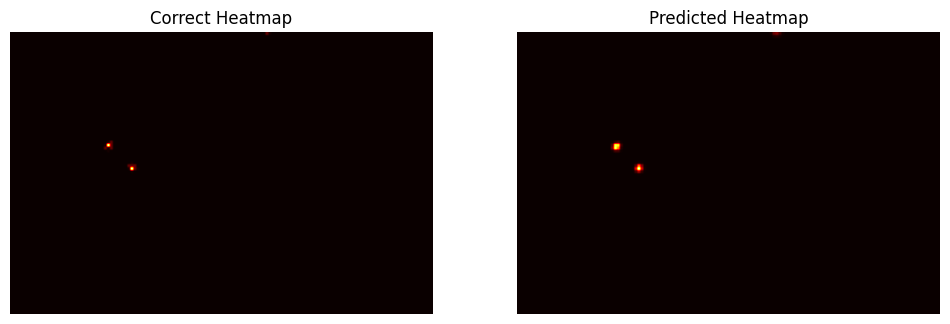

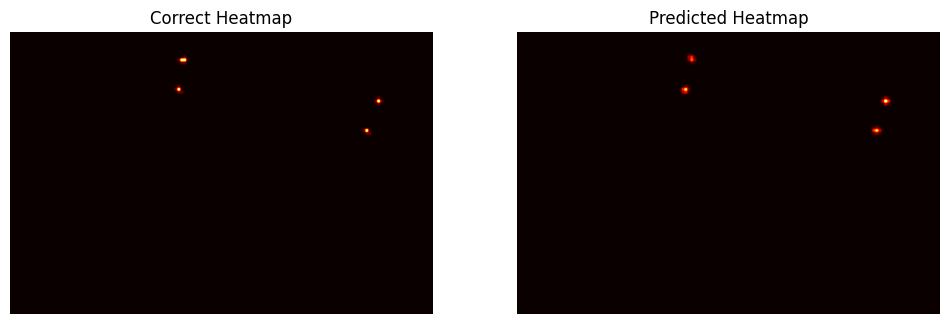

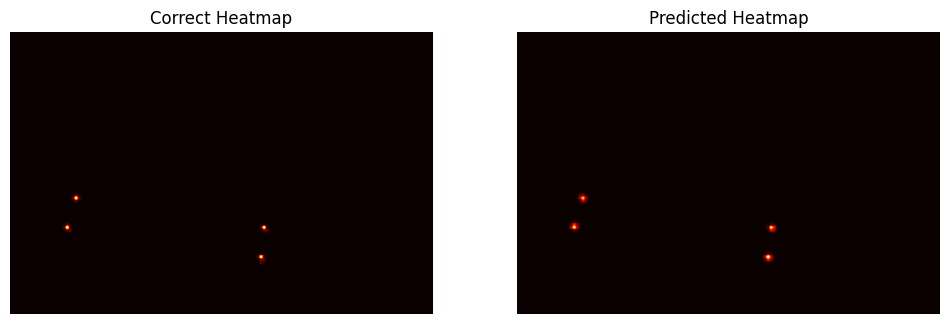

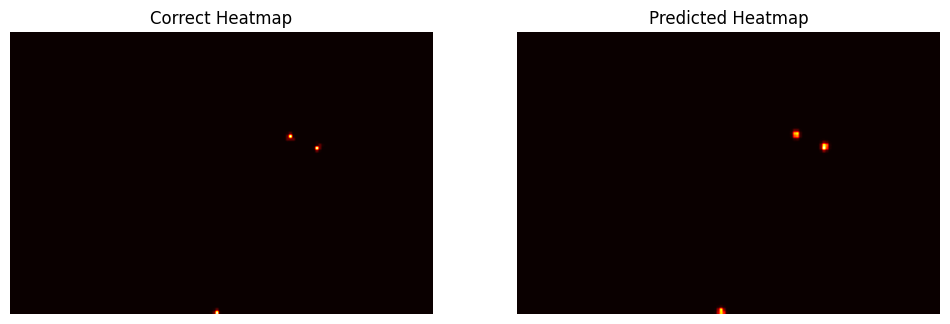

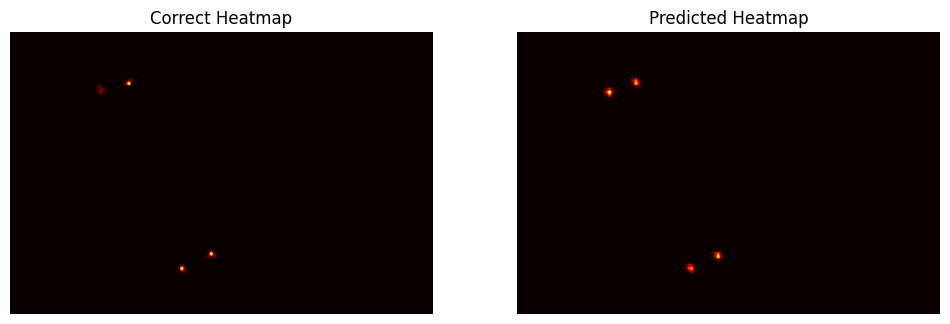

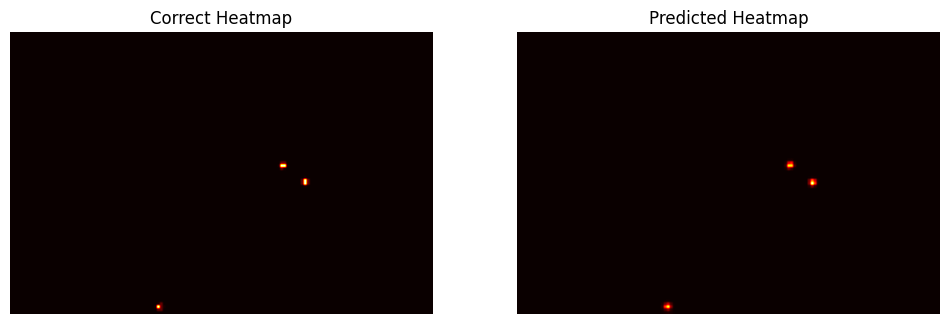

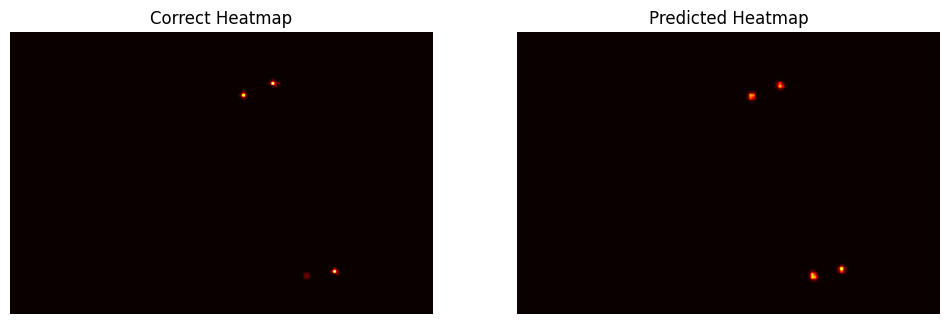

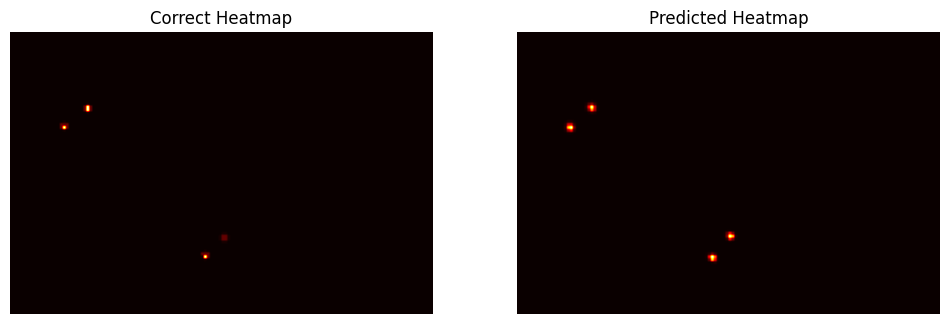

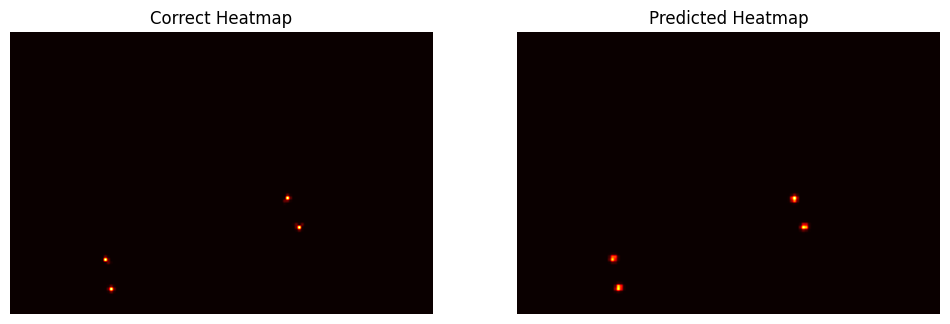

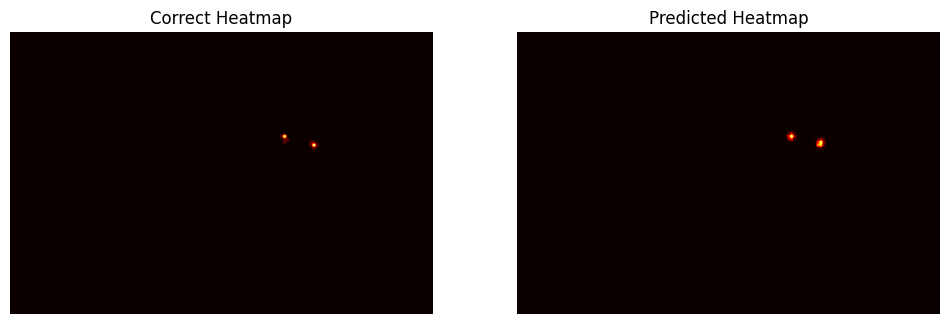

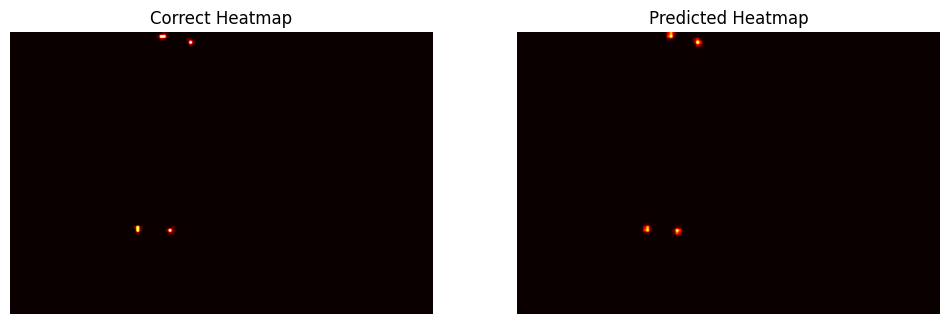

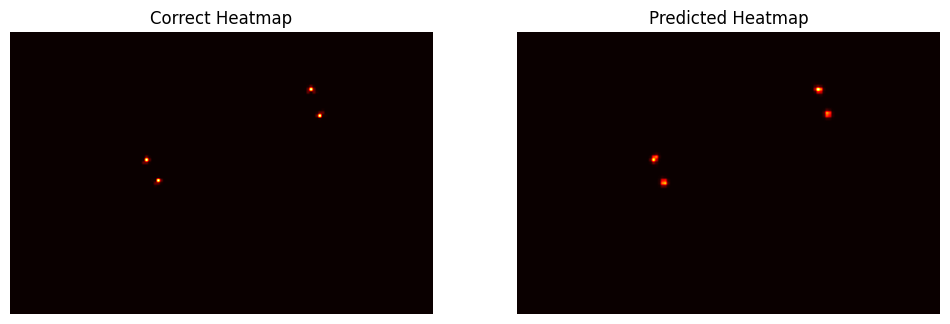

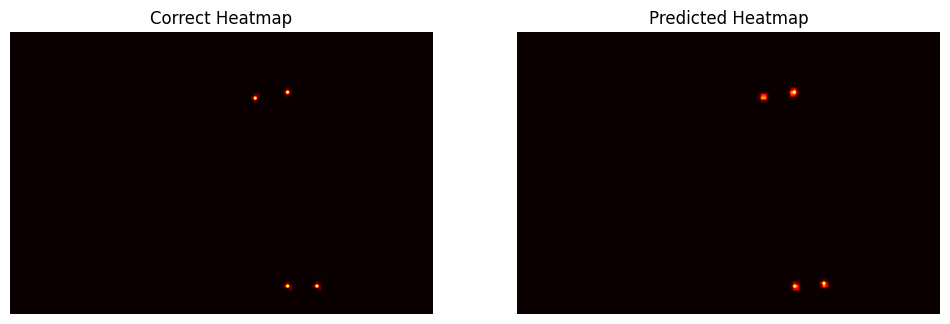

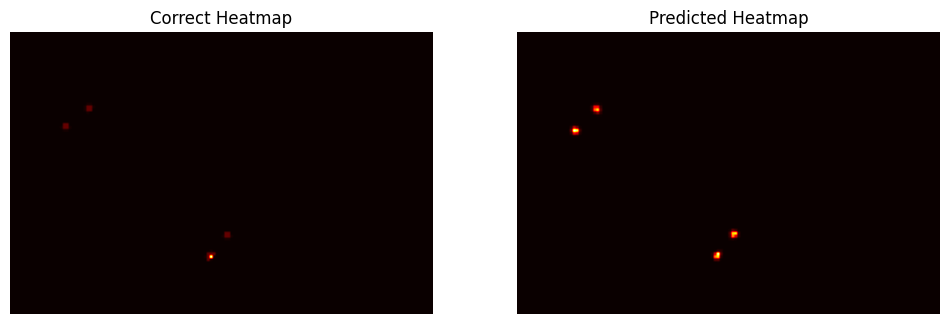

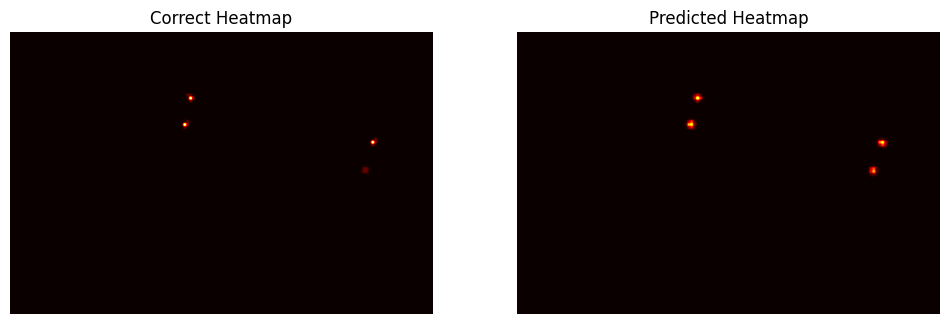

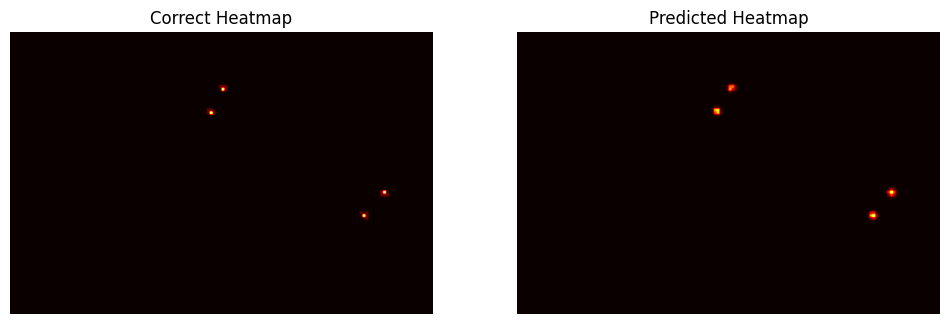

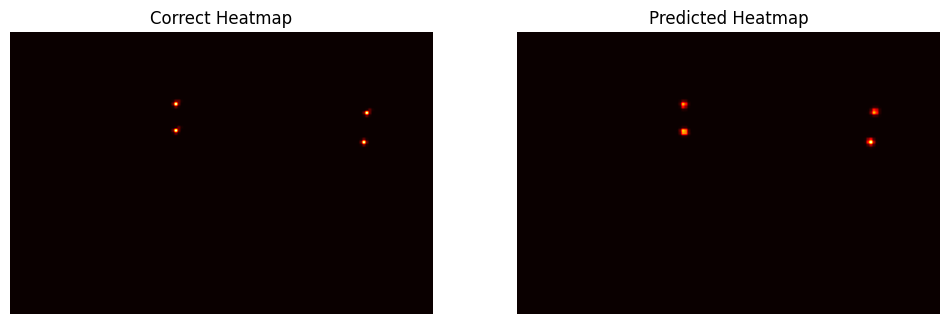

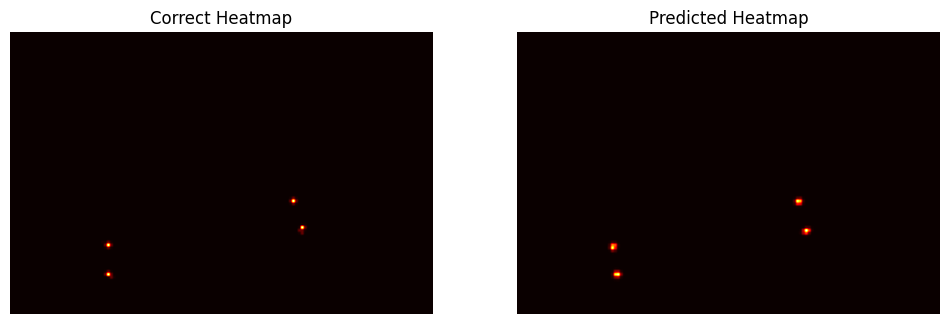

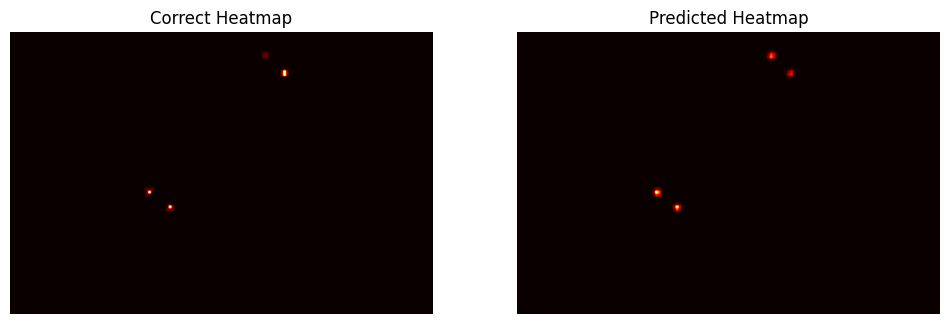

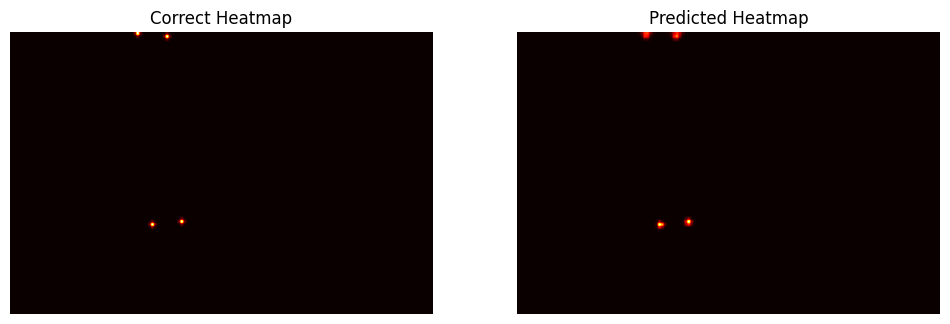

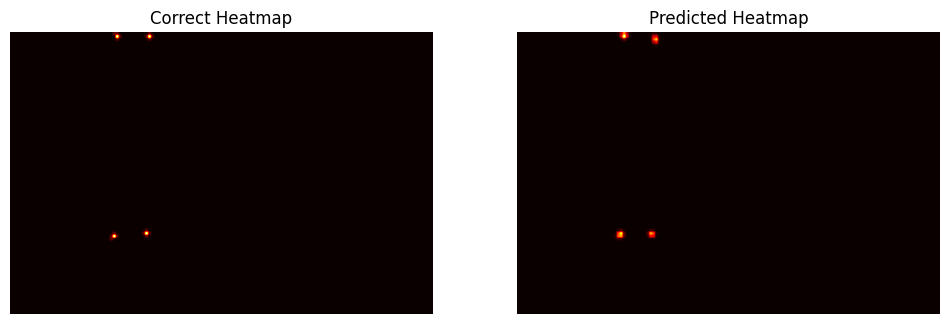

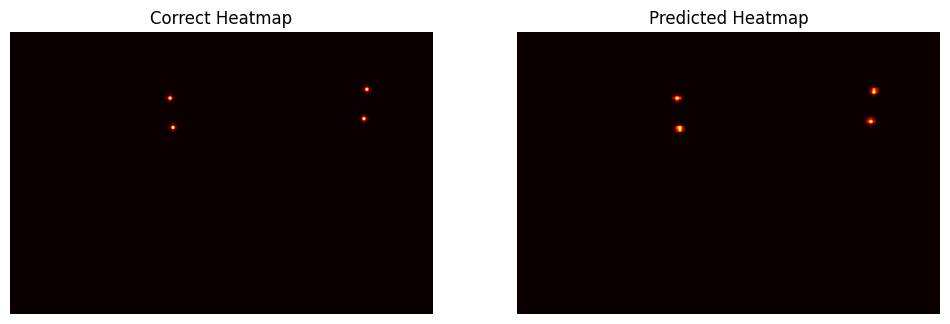

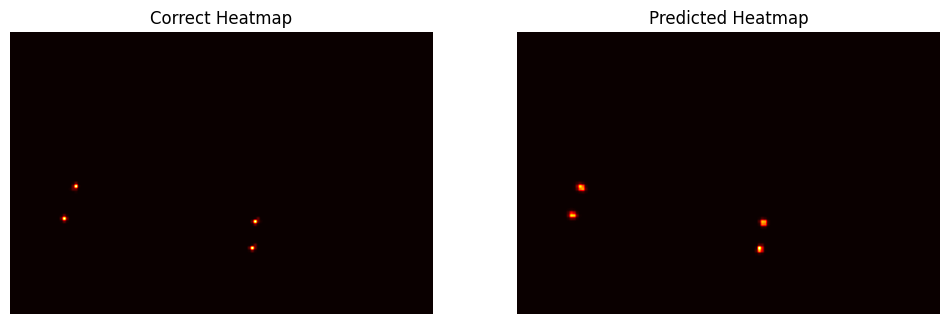

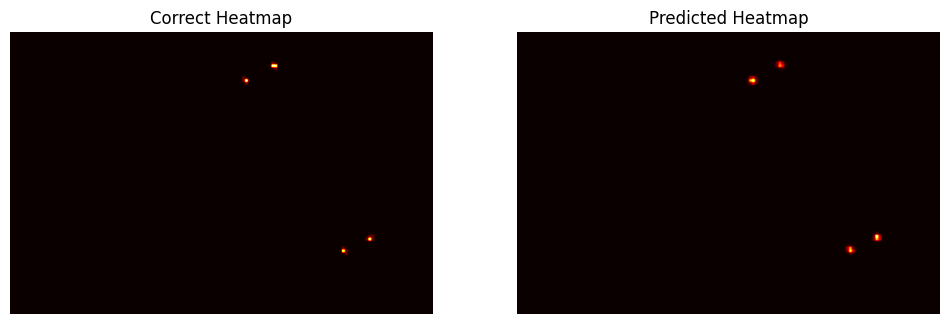

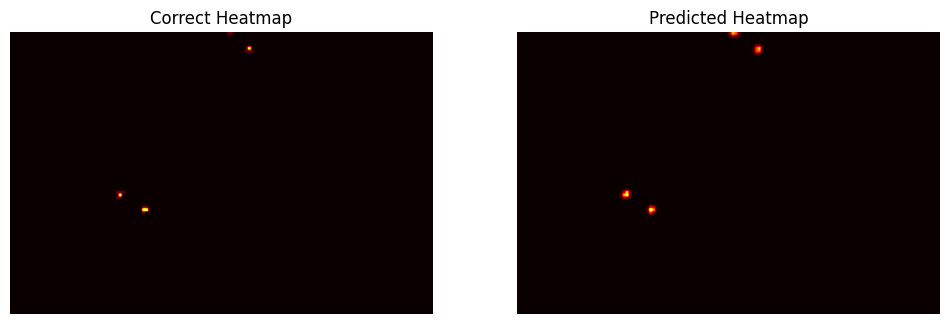

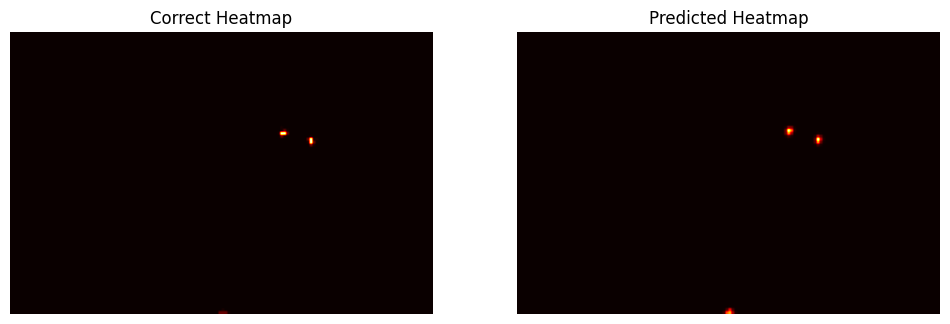

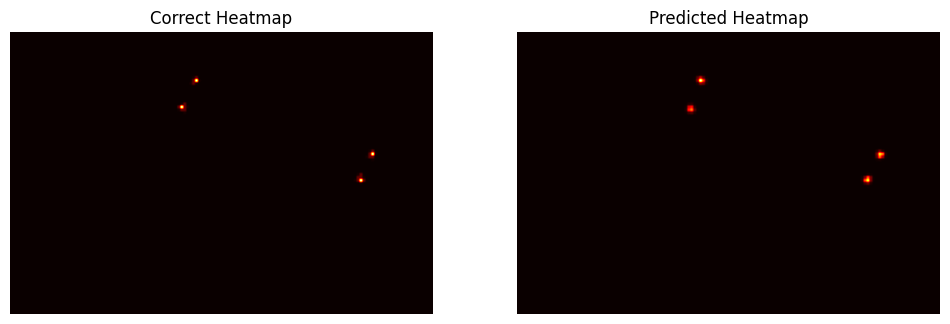

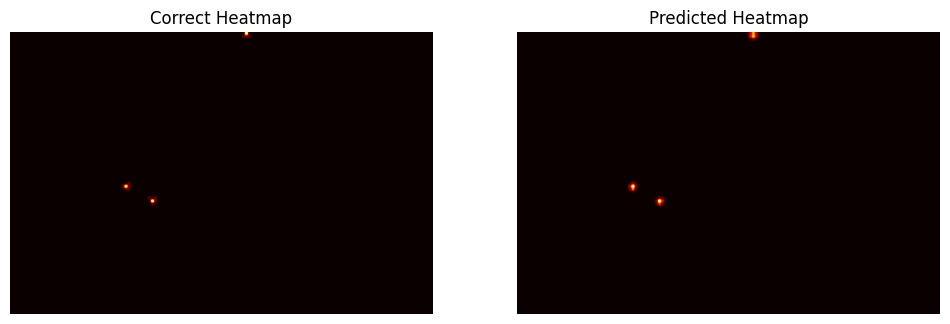

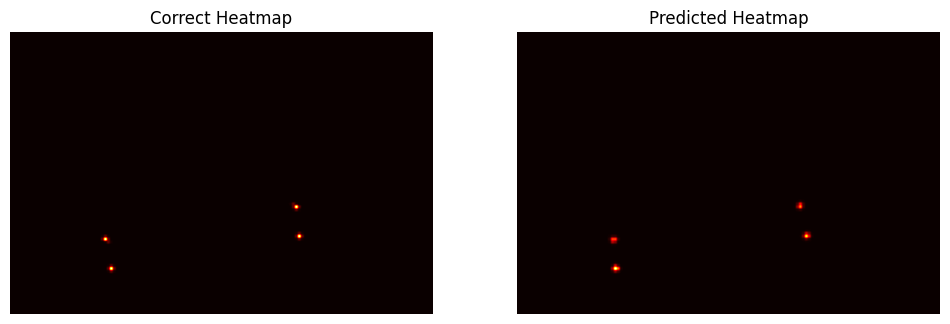

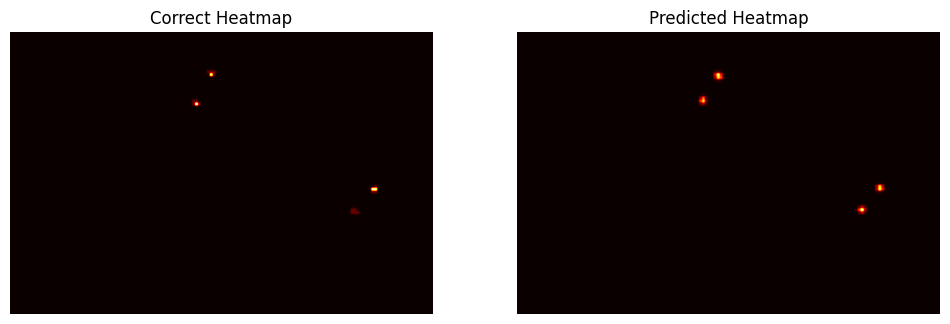

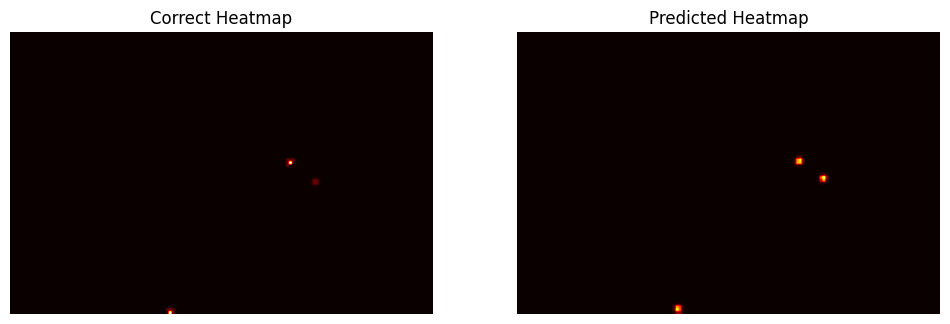

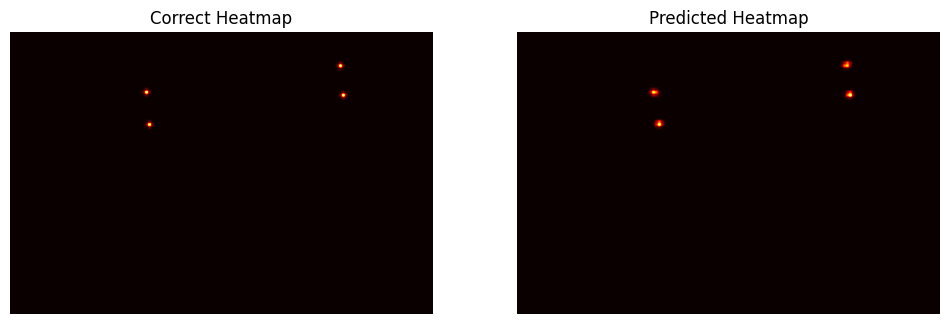

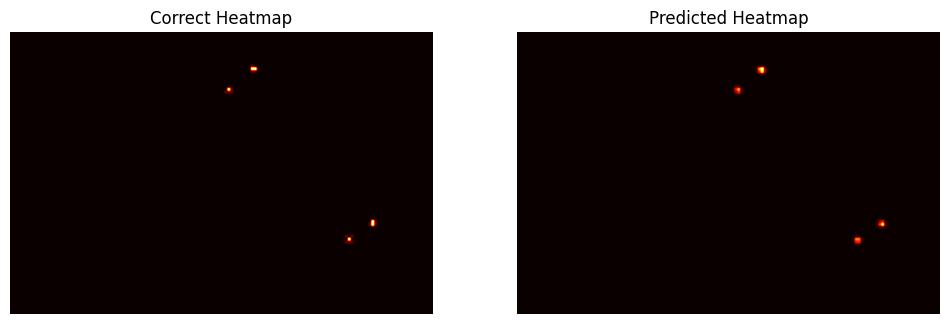

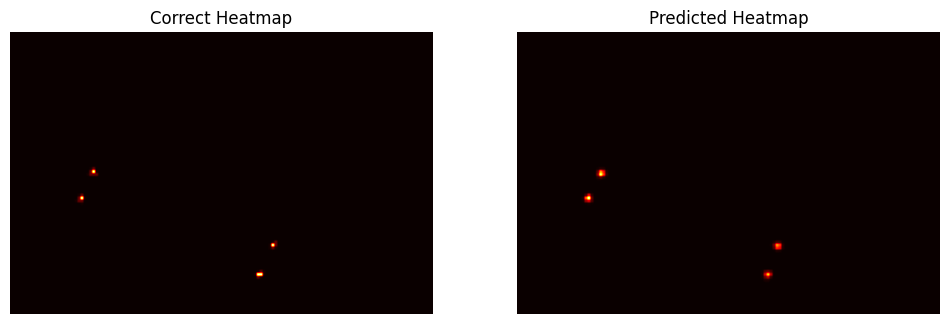

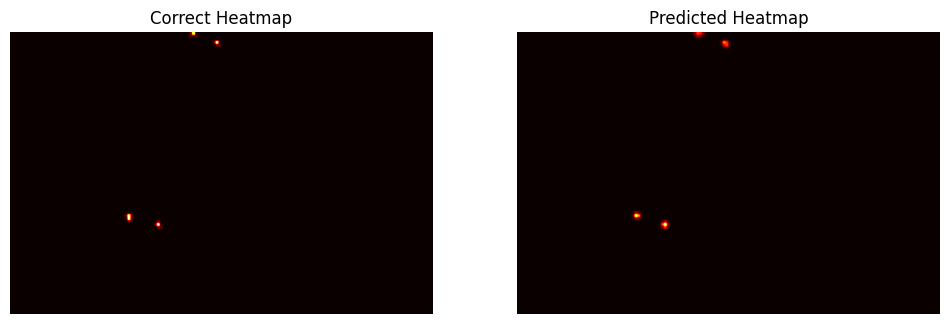

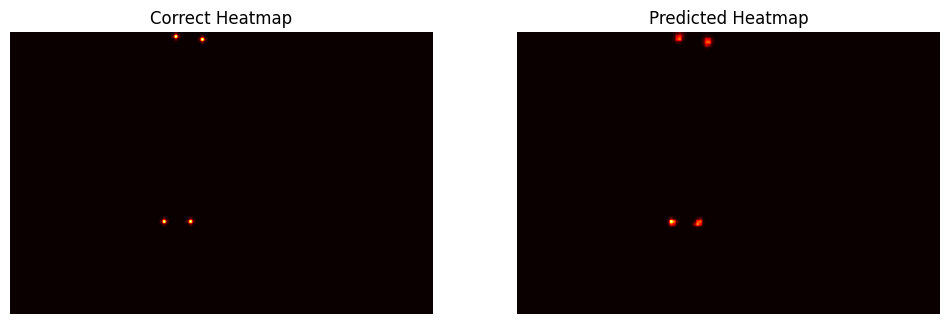

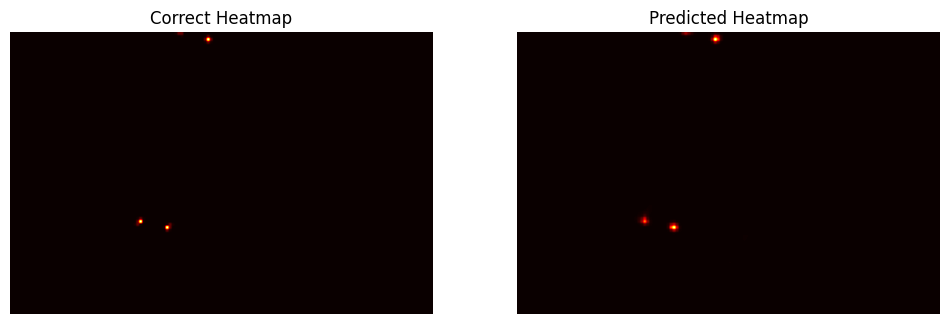

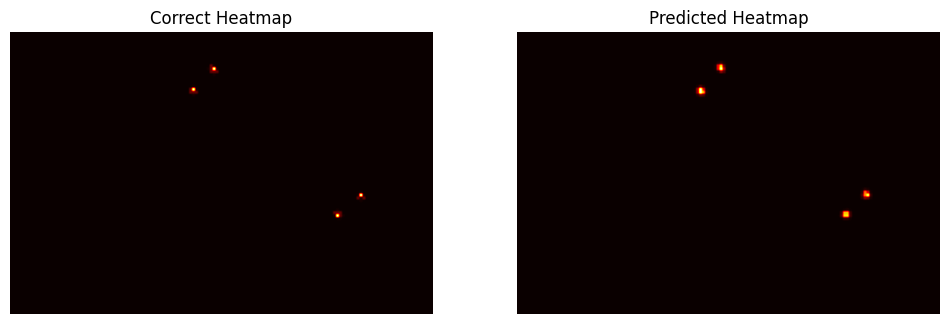

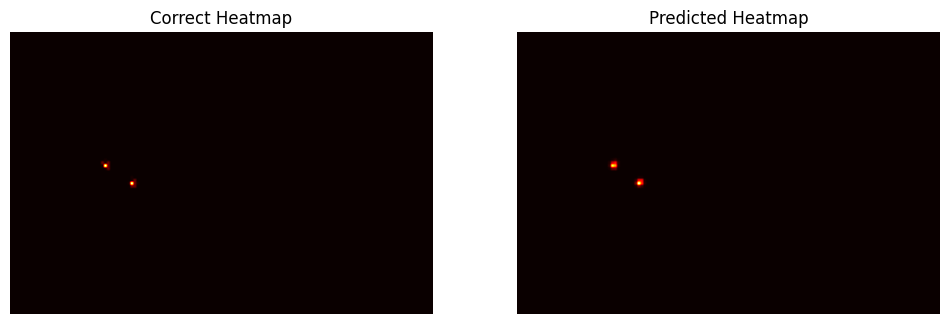

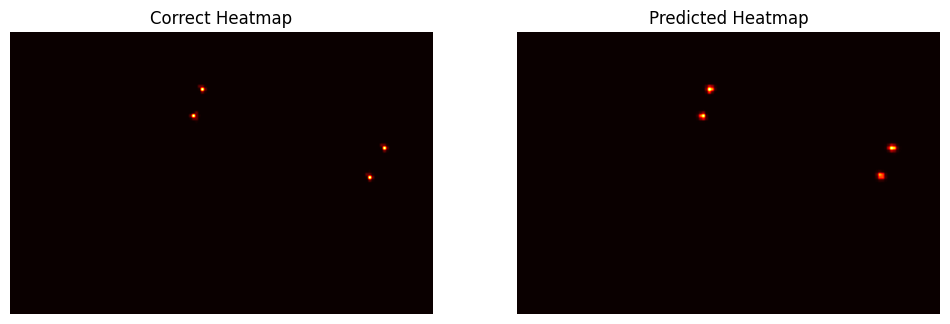

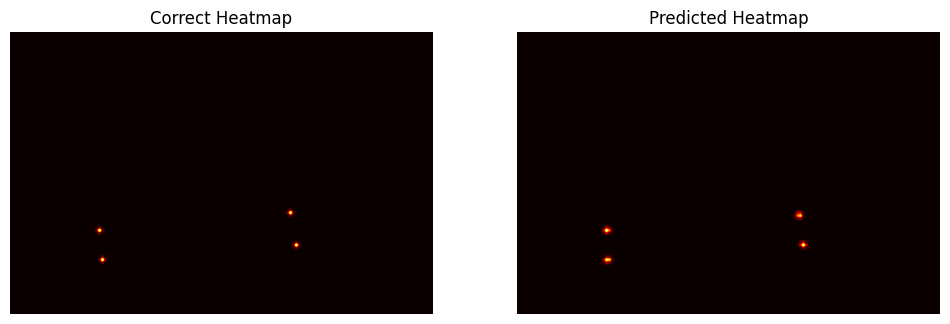

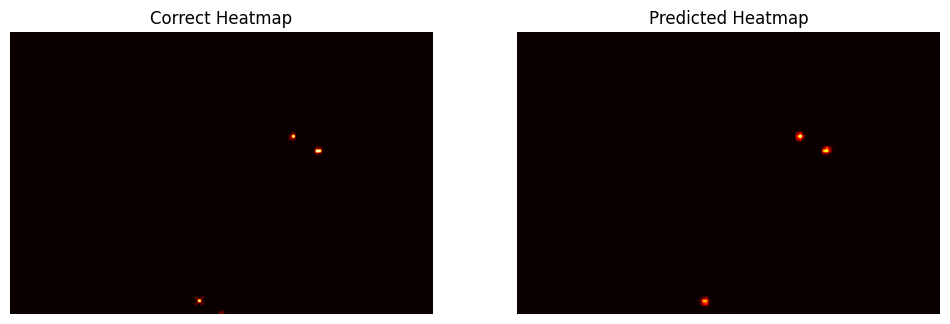

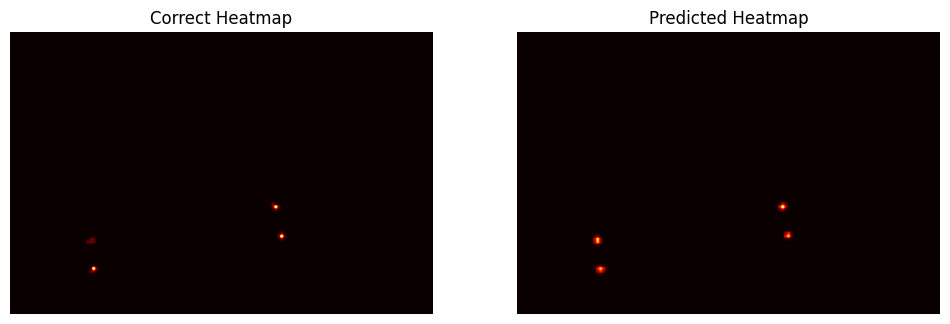

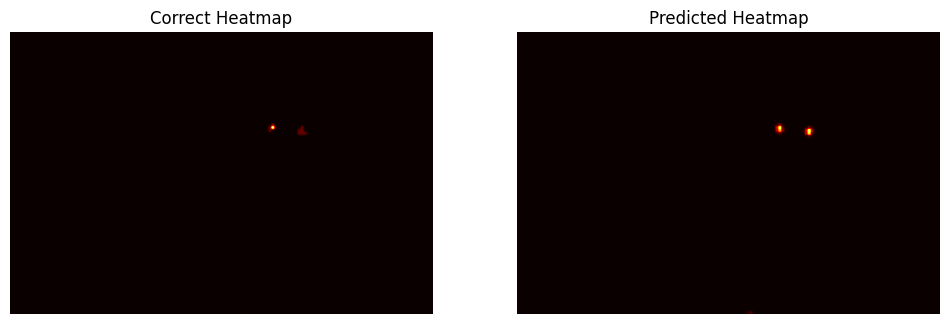

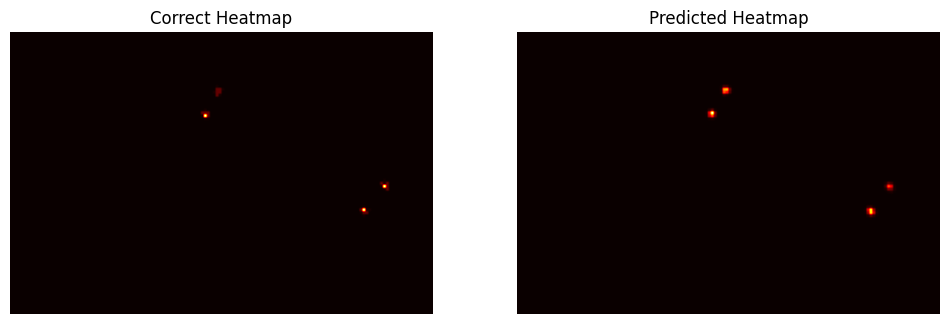

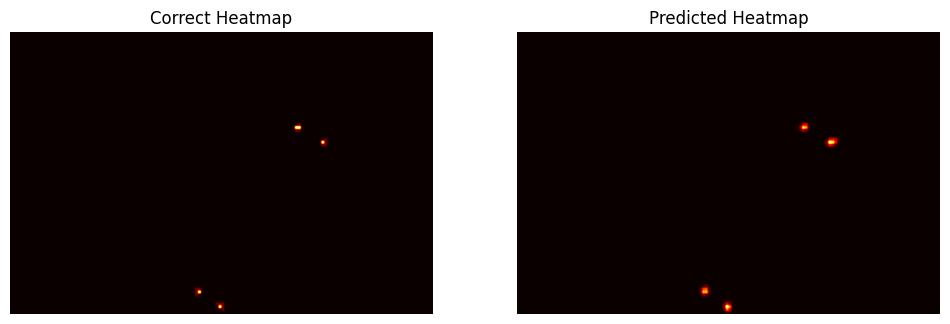

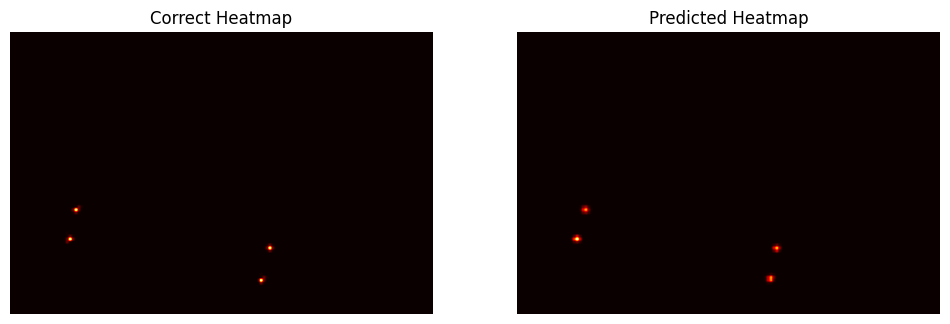

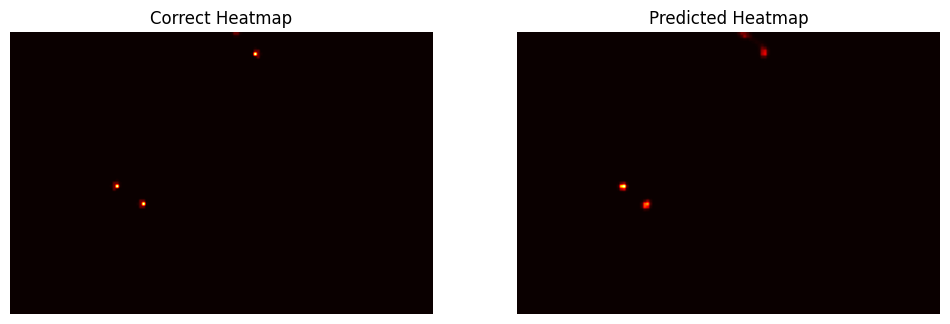

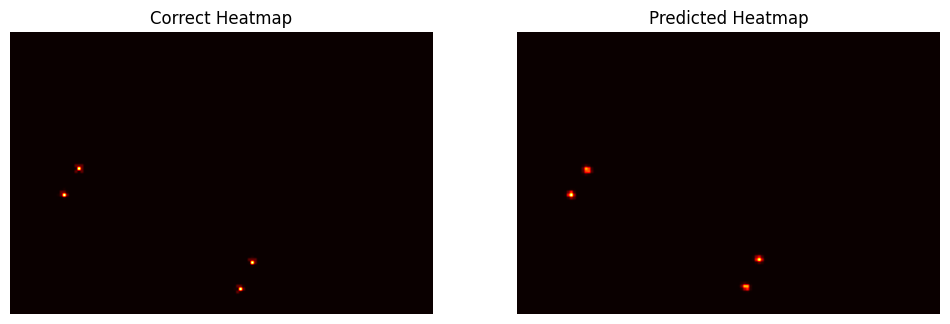

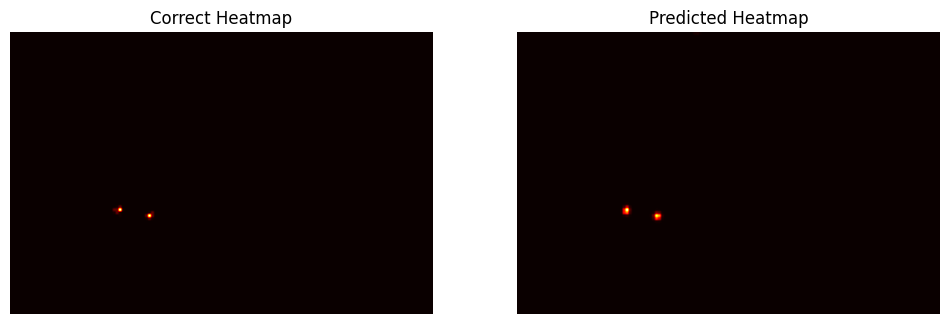

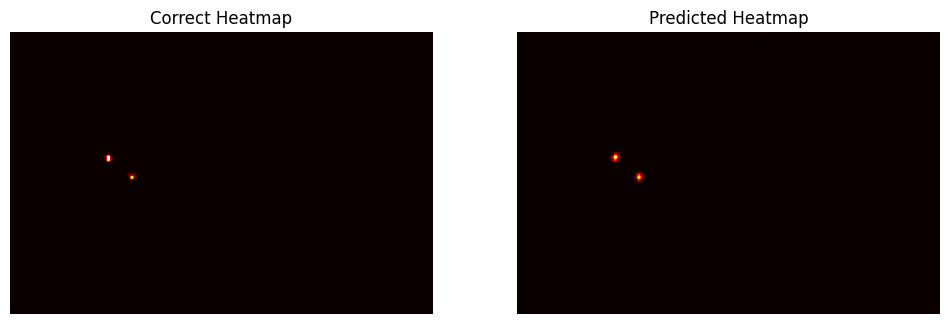

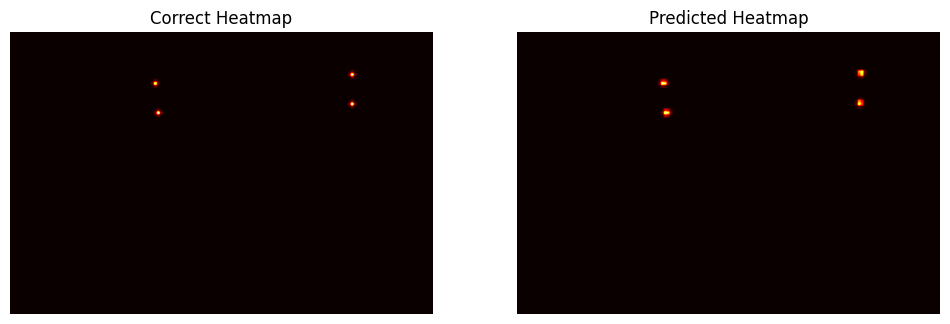

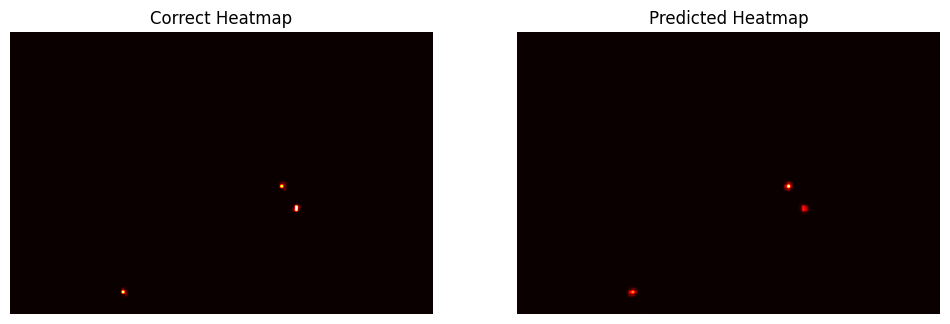

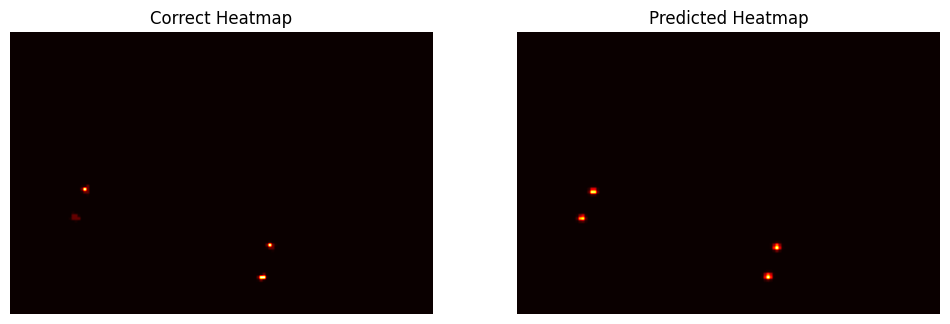

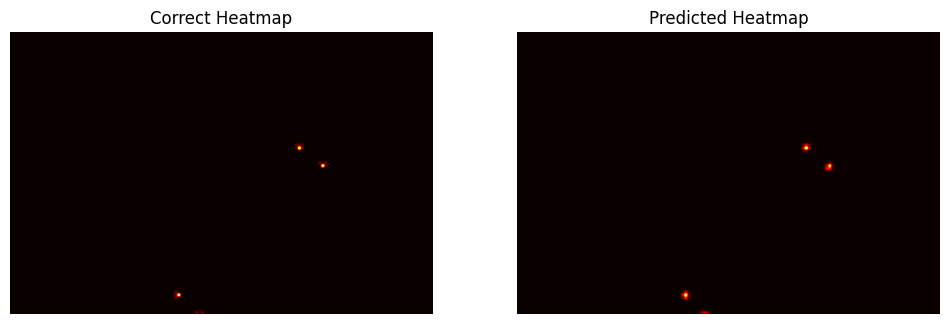

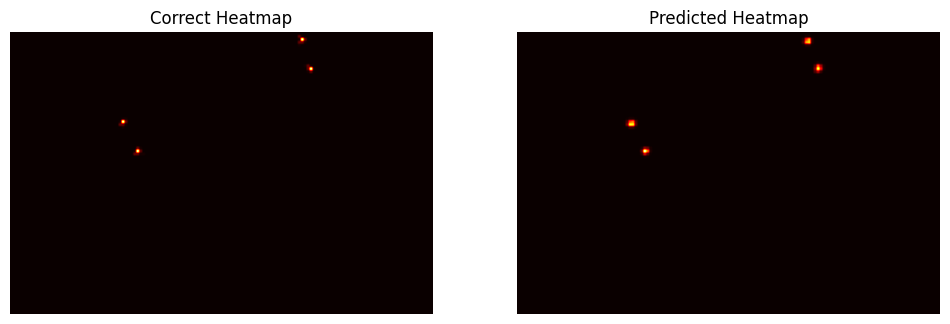

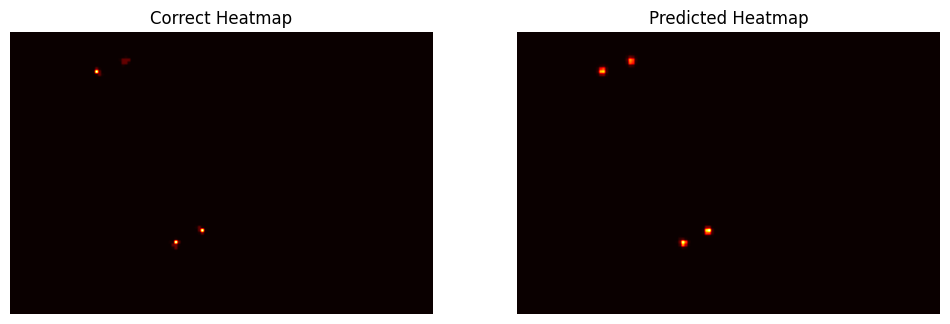

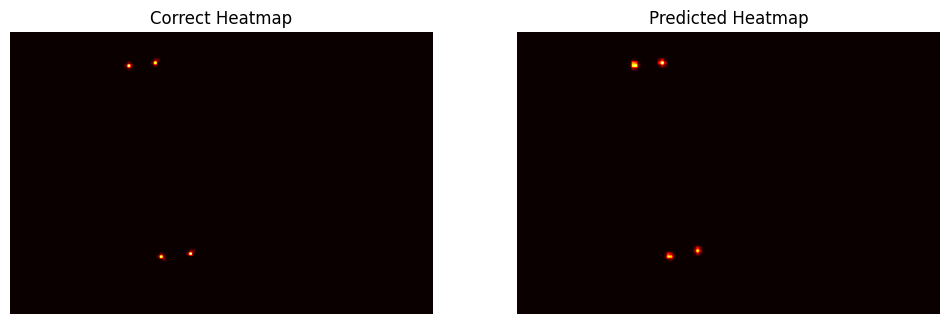

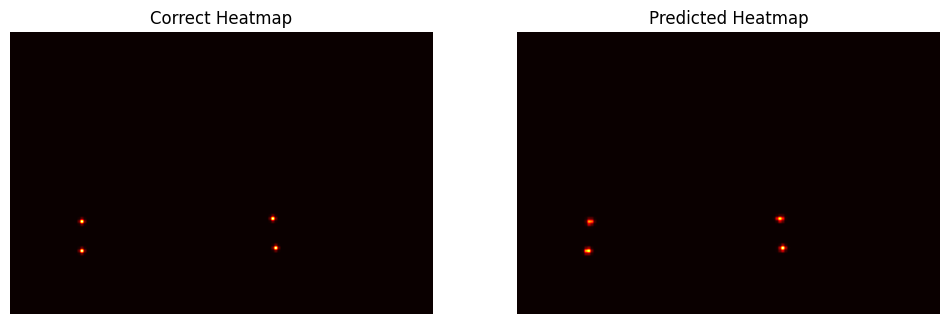

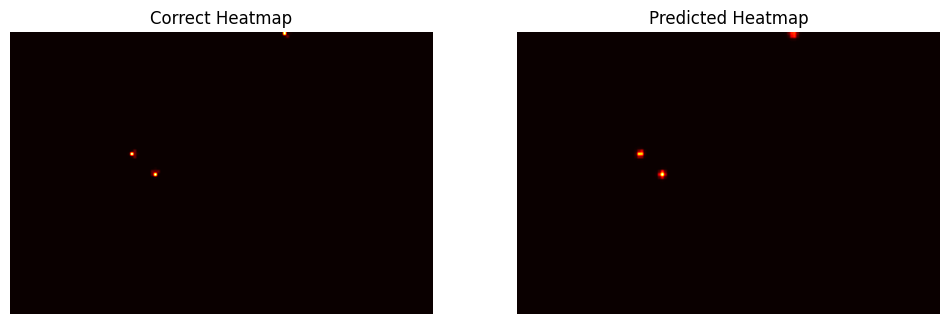

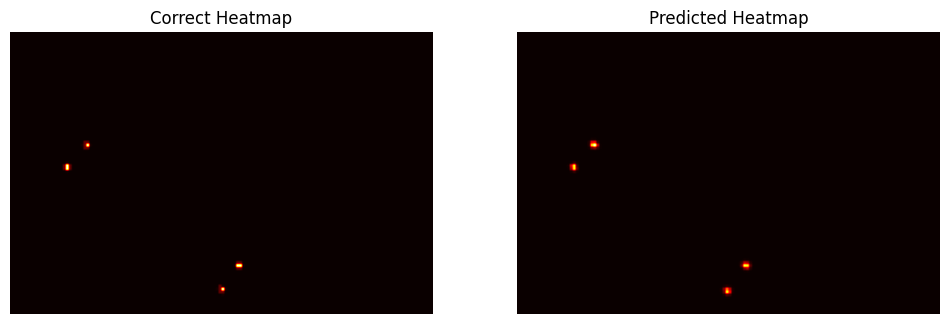

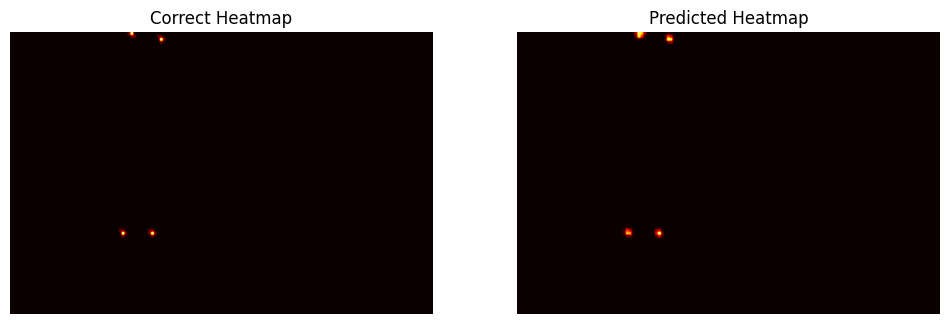

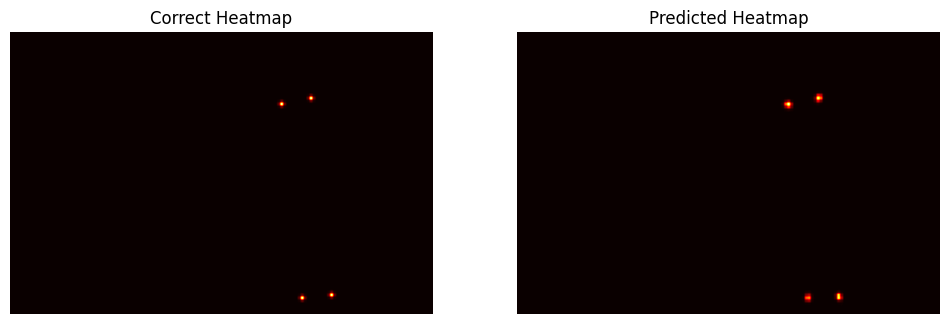

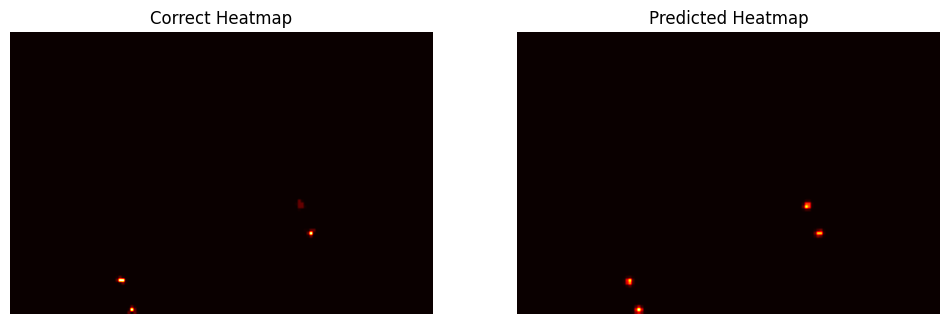

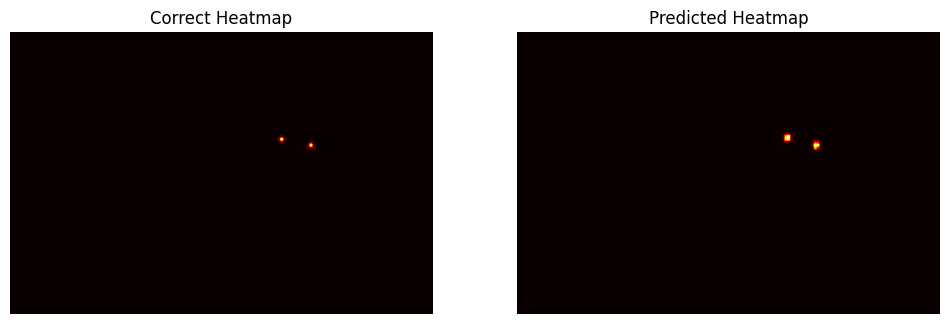

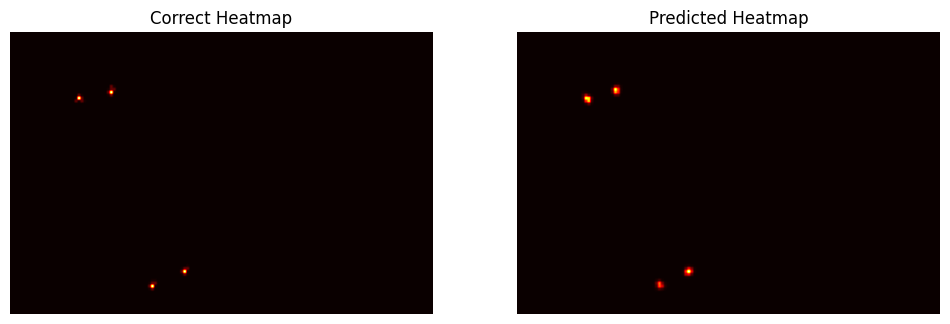

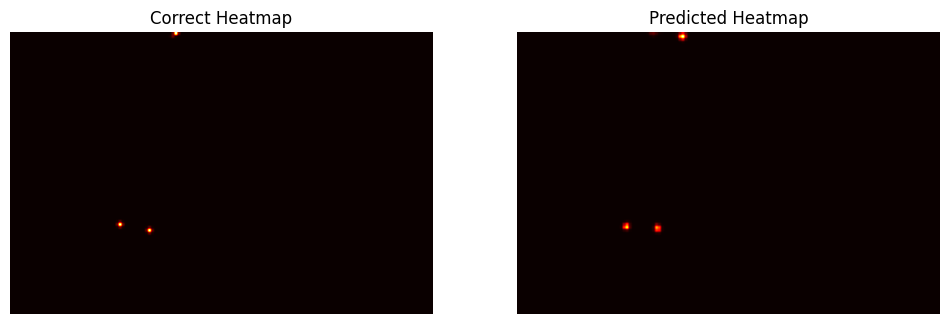

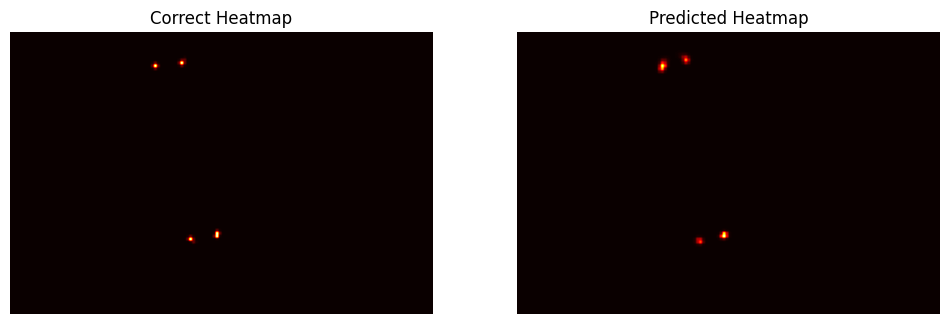

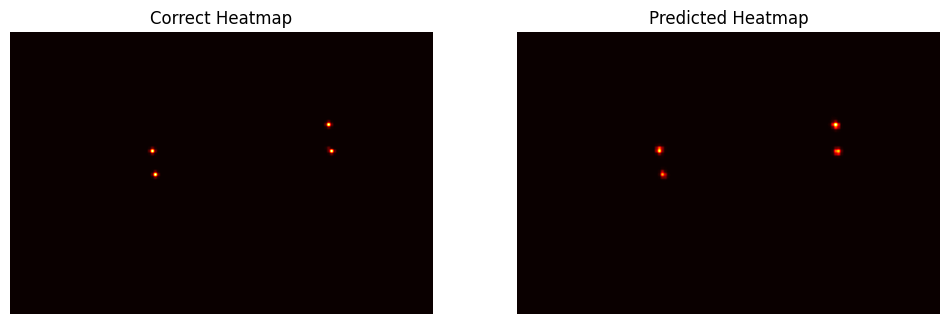

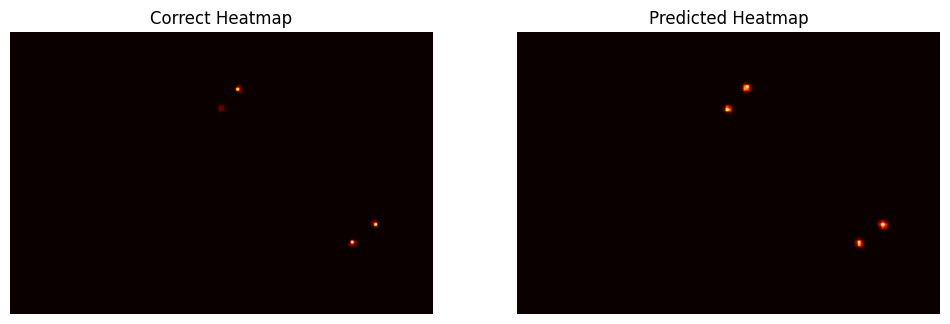

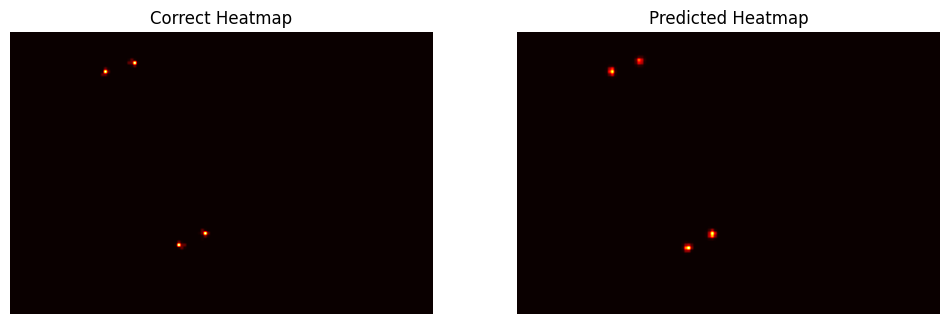

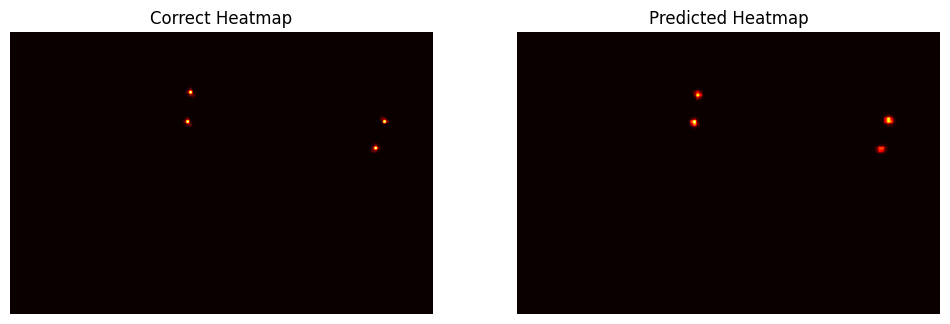

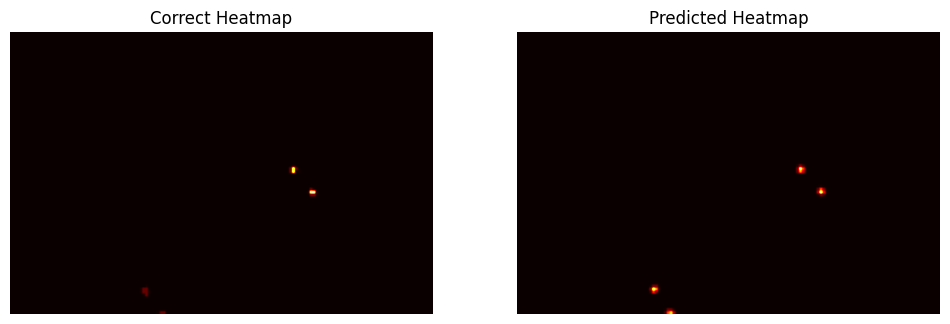

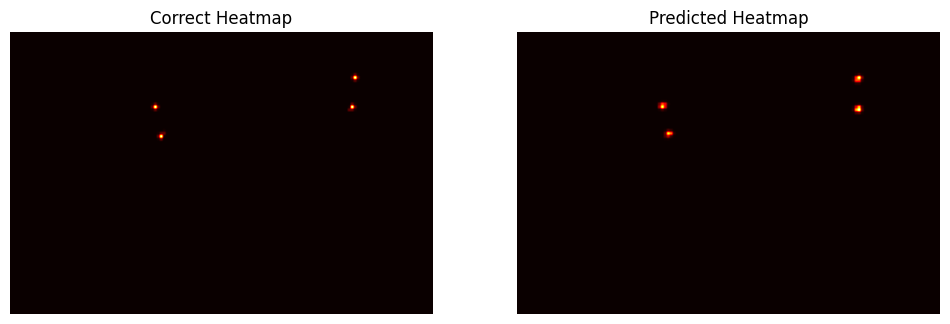

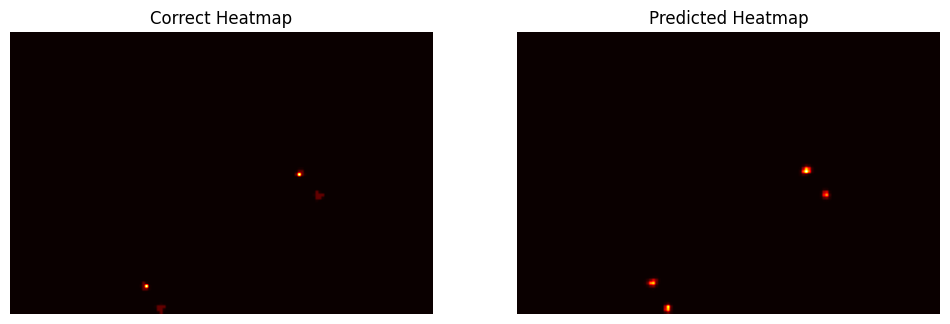

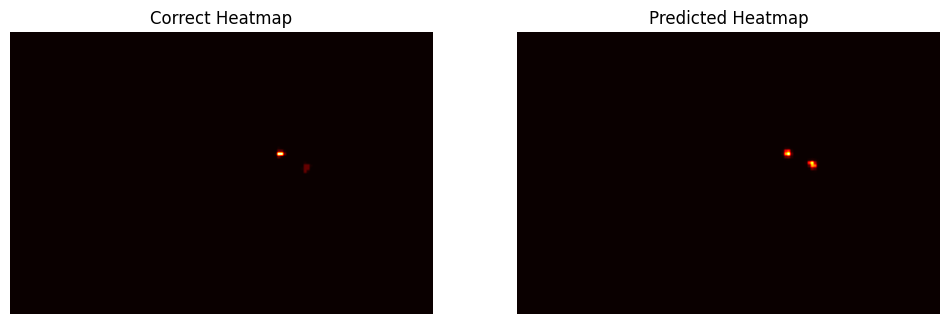

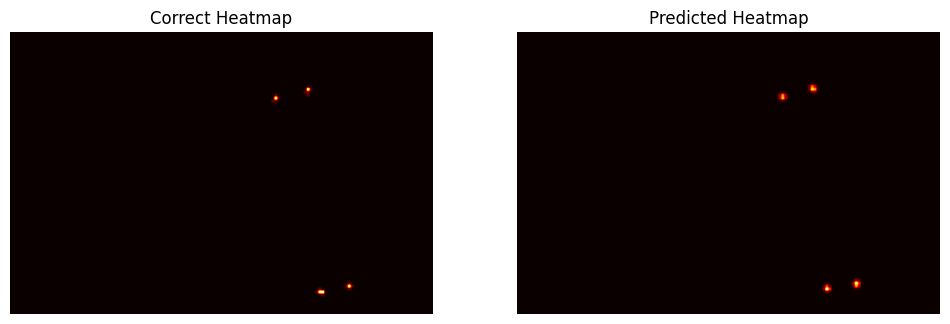

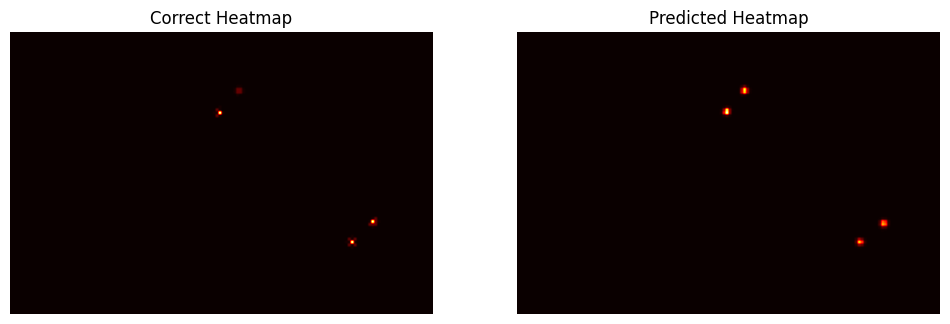

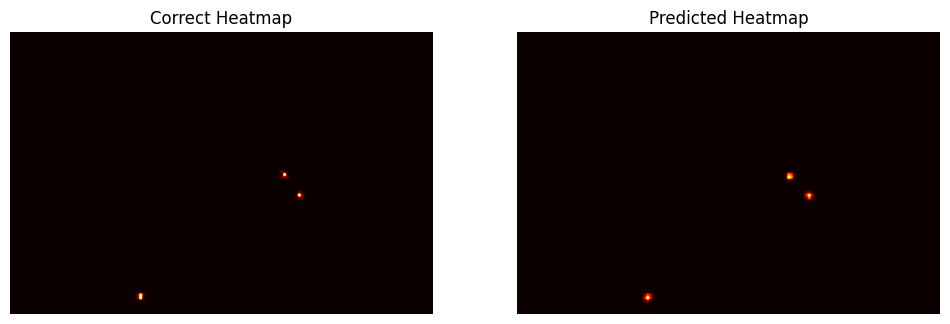

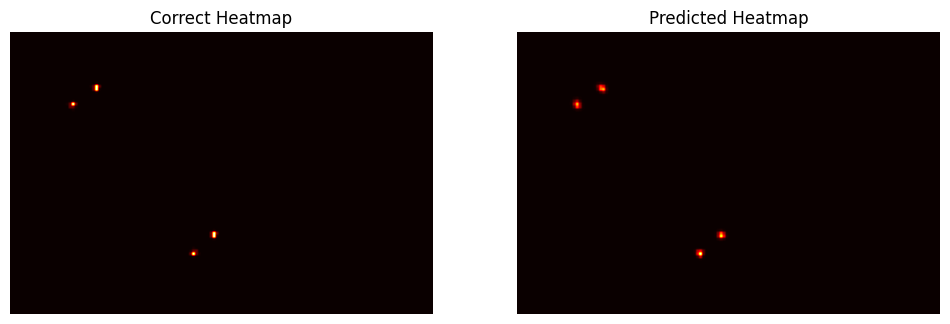

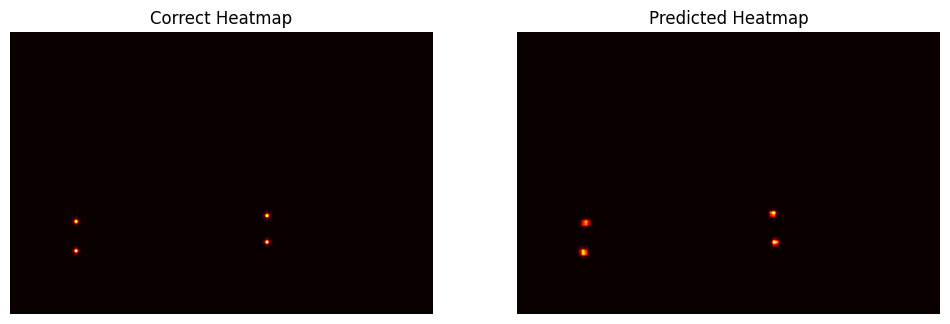

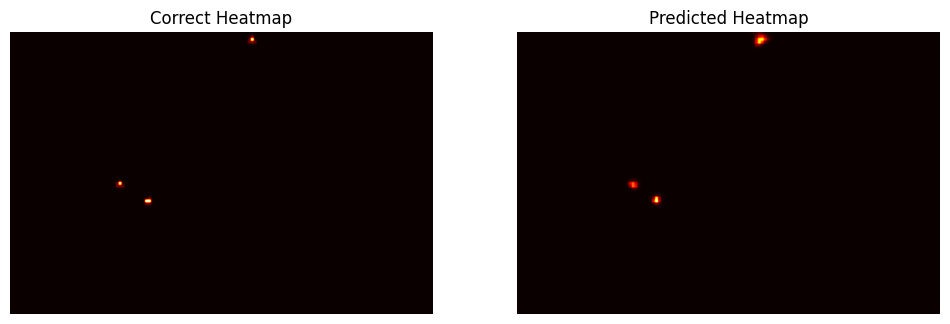

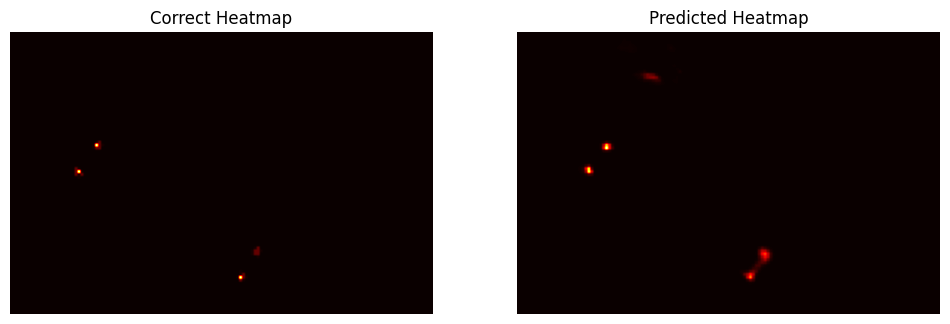

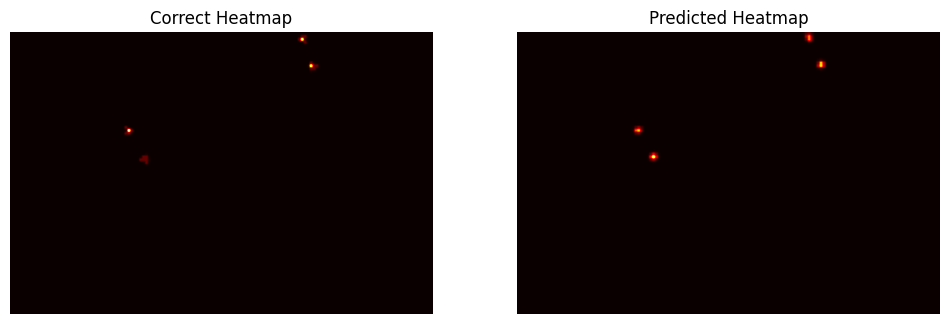

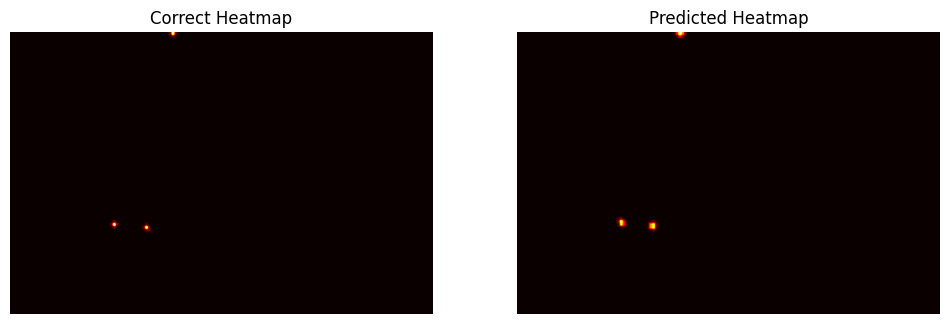

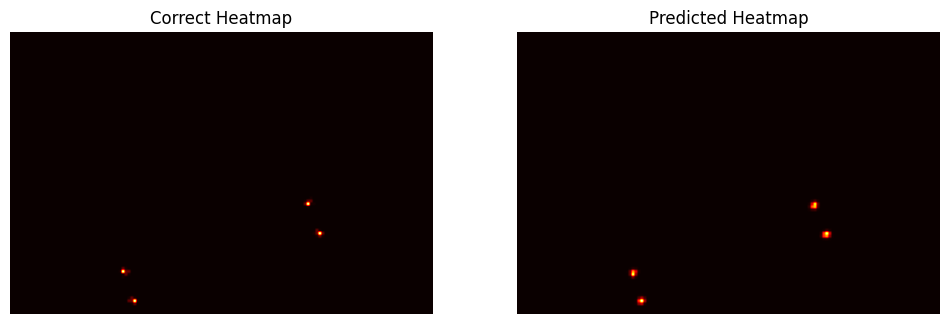

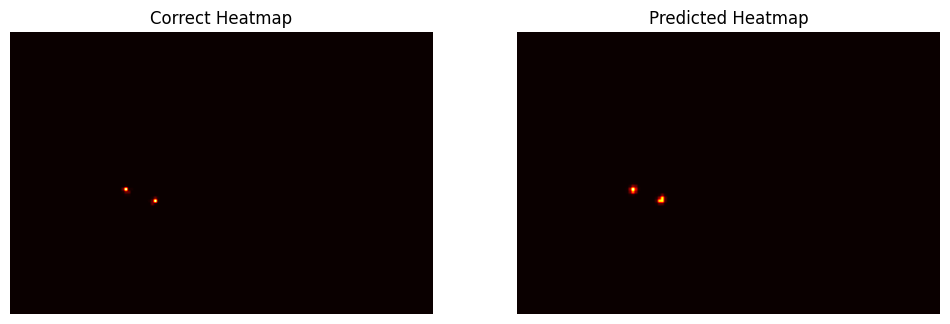

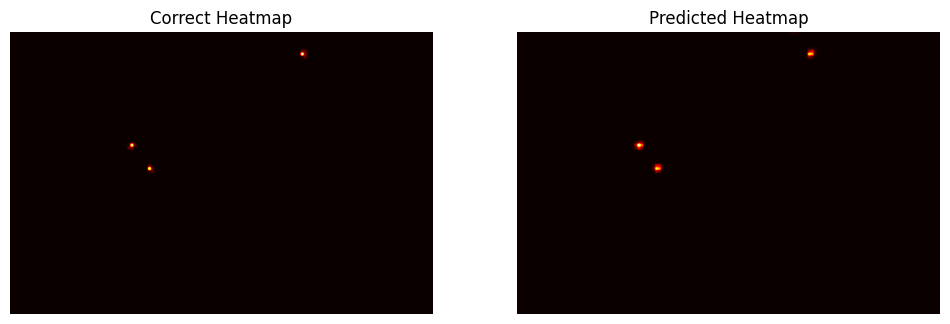

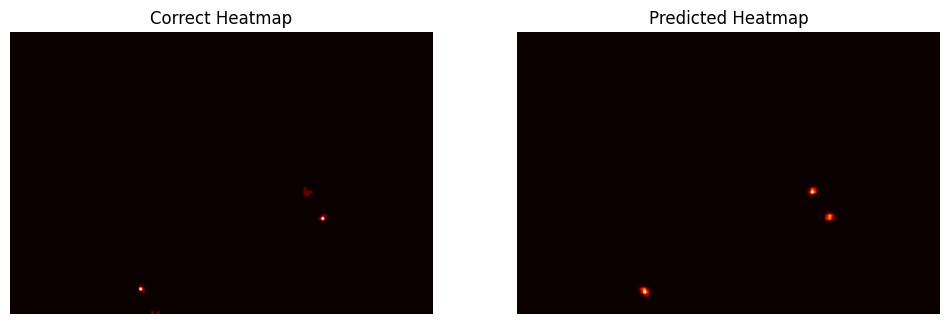

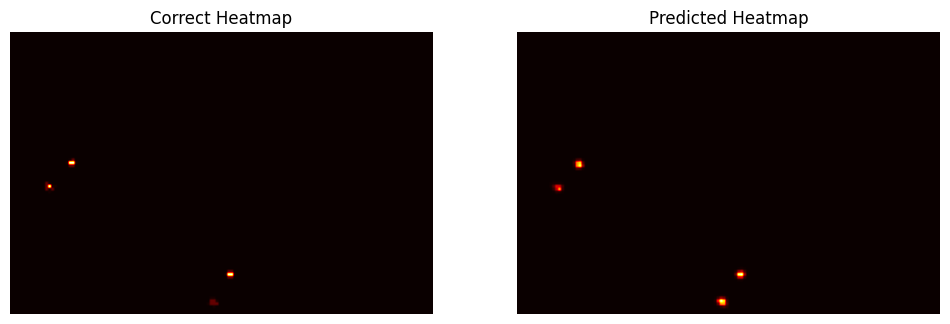

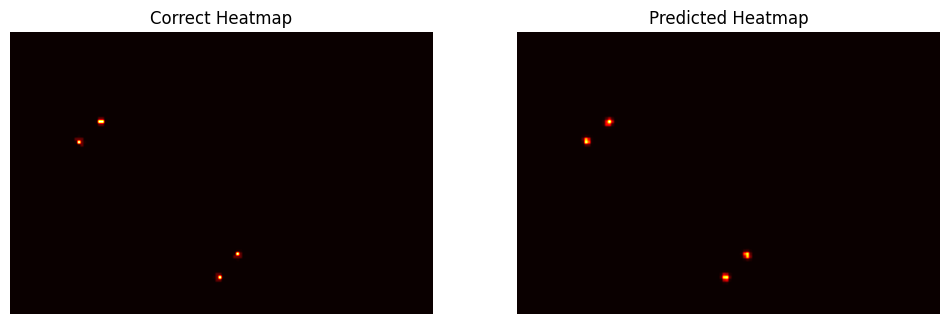

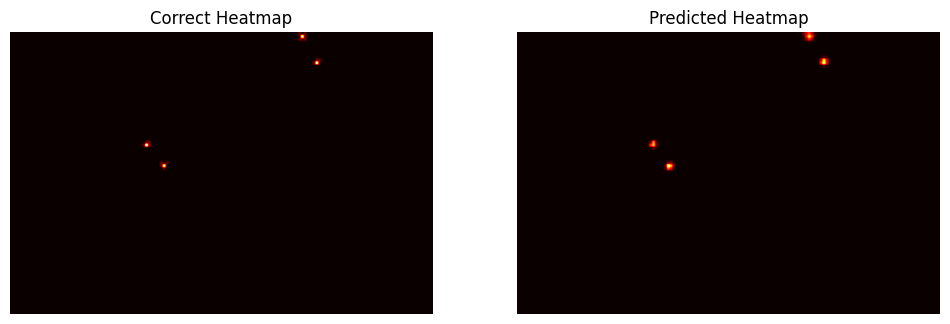

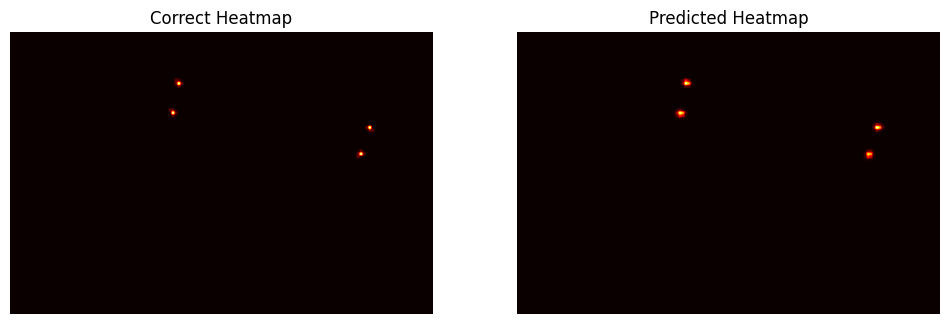

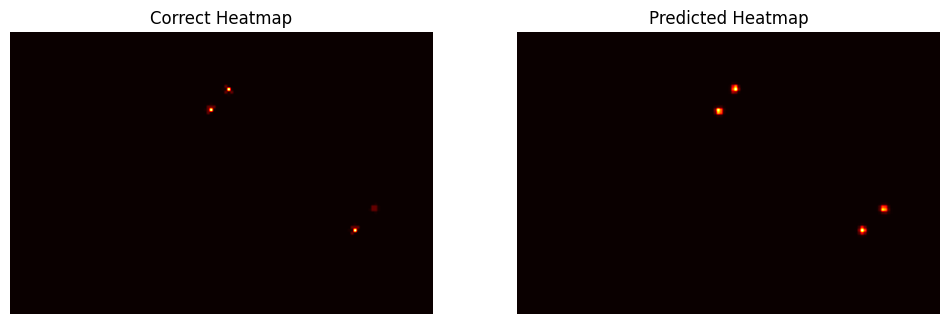

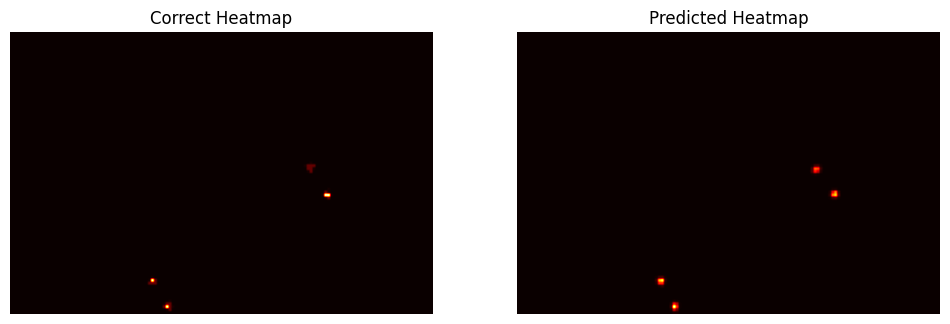

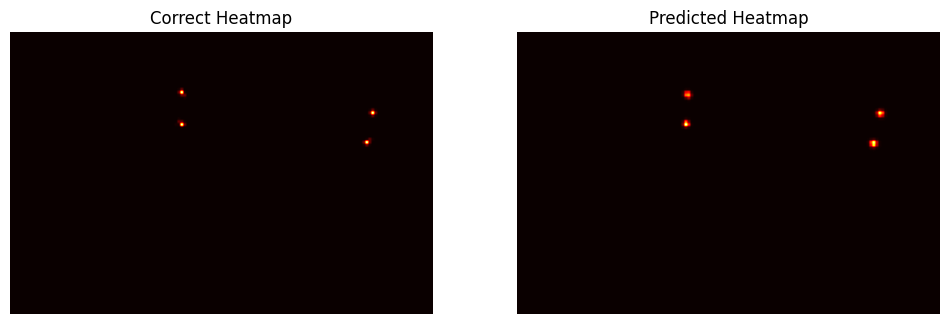

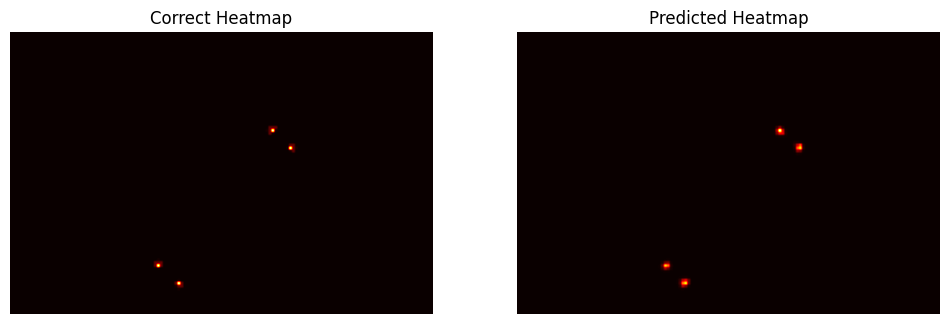

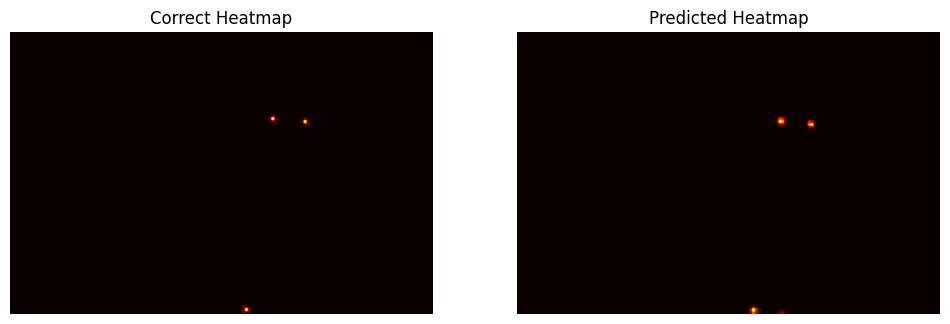

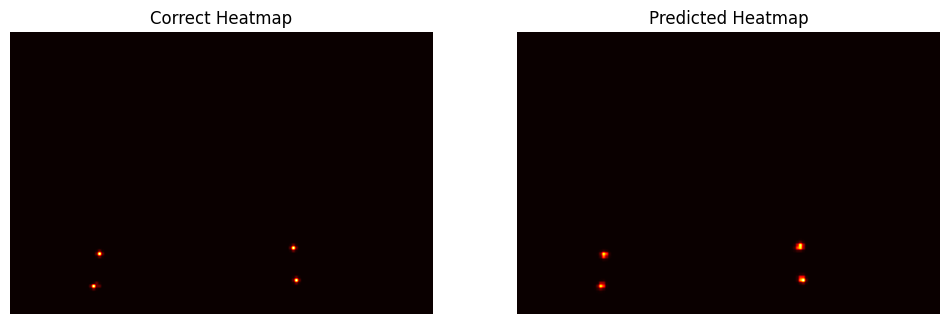

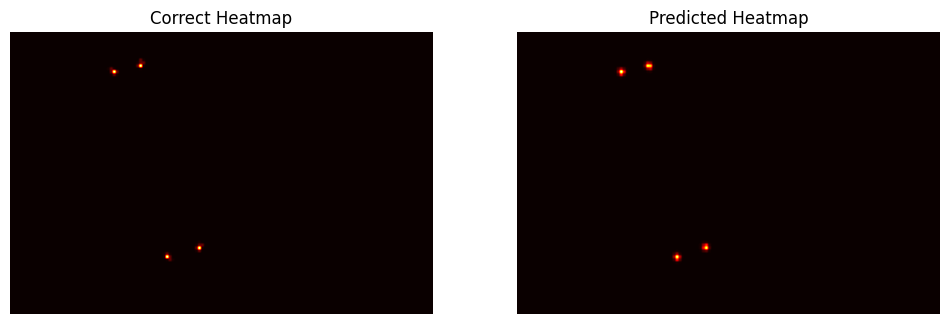

In [21]:
import numpy

correct_predictions = 0

for batch_num, (images, heatmaps) in enumerate(validation_dataset):
    # Nimm das erste Bild aus dem Batch (z. B. das erste Bild und Heatmap)
    image = images[0].numpy()
    heatmap = heatmaps[0].numpy()  # Wandeln Sie Tensor in NumPy-Array um

    # # # Visualisierung des Bildes und der Heatmap
    # fig, axes = plt.subplots(1, 1, figsize=(8, 6))

    # # Bild anzeigen
    # axes.imshow(image)  # Bild anzeigen
    # axes.set_title("Input Image")
    # axes.axis("on")  # Achsen ausblenden

    # Heatmap anzeigen
    # axes.imshow(
    #     image.squeeze() * 0.5 + heatmap.sum(axis=2)[:, :, np.newaxis], cmap="Greens"
    # )
    # axes.imshow(heatmap.sum(axis=2)[:,:,np.newaxis], cmap='hot')

    # Berechnung der prediction
    prediction = model.predict(images)
    prediction = prediction[0]
    prediction_image = prediction[:, :, :]

    # Visualisiere das Heatmap-Bild des Labels
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Größe angepasst, um beide Bilder nebeneinander zu zeigen
    axes[0].imshow(heatmap, cmap="hot")
    axes[0].set_title("Correct Heatmap")
    axes[0].axis("off")  # Achsen ausblenden (das war vermutlich die Intention)
    axes[0].grid(True)  # Gitterlinien anzeigen
    axes[0].set_xticks(np.arange(0, image.shape[1], 5))  # X-Achse Gitterlinien alle 5 Pixel
    axes[0].set_yticks(np.arange(0, image.shape[0], 5))  # Y-Achse Gitterlinien alle 5 Pixel

    # Visualisiere das Heatmap-Bild der Prediction
    axes[1].imshow(prediction_image, cmap="hot")  # Hier wird die Heatmap der Vorhersage dargestellt
    axes[1].set_title("Predicted Heatmap")
    axes[1].axis("off")  # Achsen ausblenden (das war vermutlich die Intention)
    axes[1].grid(True)  # Gitterlinien anzeigen
    axes[1].set_xticks(np.arange(0, prediction_image.shape[1], 5))  # X-Achse Gitterlinien alle 5 Pixel
    axes[1].set_yticks(np.arange(0, prediction_image.shape[0], 5))  # Y-Achse Gitterlinien alle 5 Pixel

    # Bestimmung der Punkte aus Label und Prediction
    prediction_points, heatmappoints = pointdetection(prediction, heatmap)

    # Korrektur der List aus den 10 Punkten werden die höchsten 4 punkte mit mindest abstand von 4 pixeln gewählt
    prediction_points = listcorrection(prediction_points)
    heatmappoints = listcorrection(heatmappoints)
    # Berechnung der korrekt detektierten Ecken wenn die Anzahl an Punkten aus Label und Prediction stimmen
    if len(prediction_points) == len(heatmappoints):
        print("länge ht", len(heatmappoints), heatmappoints)
        print("länge pred", len(prediction_points), prediction_points)

        # Berechnung der prozuentalen Anteil an korrekten Predictions
        prediction_points, correct_prediction = validate_prediction(
            prediction_points, heatmappoints
        )
    else:  # Wenn Anzahl der Punkte nicht über einstimmt -> Falsche Prediction bzw. Fehler
        correct_prediction = 0
  
    correct_predictions += correct_prediction
    correct_validations = 100 * (correct_predictions / (batch_num + 1))

    print(correct_validations, "Prozent der validierungs predictions sind korrekt")